In [1]:
import numpy as np
from matplotlib import pyplot as plt
import scipy.io
from scipy.stats import spearmanr, pearsonr

#=================================================================================================#

from utils import interventional as IC
from utils import load_data as ld
from utils import load_EC as lec
from utils import colormaps as maps
from utils import plot as pl
from utils import correlations as cc
from utils import distance as di

#=================================================================================================#

In [2]:
#=================================================================================================#
# For Avenir font. To use it, you have to download the font-style files below.
# Comment the lines referred to fontManager if you don't need to set the font.
from matplotlib import font_manager, rcParams
font_file   = "/home/tentori/.local/avenir_ff/AvenirLTStd-Roman.otf"
font_file_b = "/home/tentori/.local/avenir_ff/AvenirLTStd-Black.otf"
font_file_c = "/home/tentori/.local/avenir_ff/AvenirLTStd-Book.otf"
font_manager.fontManager.addfont(font_file)
font_manager.fontManager.addfont(font_file_b)
font_manager.fontManager.addfont(font_file_c)

rcParams['font.family']  = "Avenir LT Std"
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype']  = 42

DIM = 25
plt.rcParams.update({
    'font.size': DIM,
    'axes.labelsize': DIM,
    'axes.titlesize': DIM,
    'xtick.labelsize': DIM,
    'ytick.labelsize': DIM
})
#=================================================================================================#

colorz    = ['#255D93','#5FA6D6','#B02106','#F24D33','#2C2C2C','#787878']
coldhot_cmap   = maps.create_cmaphot()
coldhot_cmap_r = maps.create_cmaphot_r()

show_plot   = True

#=================================================================================================#

# to create folder
def Set_Dir_Plots(path):
    import os
    if not os.path.exists(path):
        os.mkdir(path)

## Functions

In [3]:
def ic_save(_path_,ic,ic_pval,ic_pval_FDR,suffix=''):
    
    import pickle
    with open(_path_+'ks'+suffix+'.pkl', 'wb') as f:
        pickle.dump(ic, f)

    with open(_path_+'ks_pval'+suffix+'.pkl', 'wb') as f:
        pickle.dump(ic_pval, f)

    with open(_path_+'ks_pval_FDR'+suffix+'.pkl', 'wb') as f:
        pickle.dump(ic_pval_FDR, f)
        
def ic_load(_path_,suffix=''):
    
    with open(_path_+'ks'+suffix+'.pkl', 'rb') as f:
        ic = pickle.load(f)

    with open(_path_+'ks_pval'+suffix+'.pkl', 'rb') as f:
        ic_pval = pickle.load(f)
        
    with open(_path_+'ks_pval_FDR'+suffix+'.pkl', 'rb') as f:
        ic_pval_FDR = pickle.load(f)
        
    return ic, ic_pval, ic_pval_FDR

# Parameters

In [4]:
main_path    = './Data_MaxOne/'
sim_folder   = 'Culture1REC1/'
path_imgs    = './imgs/'

path_IC_data     = main_path+sim_folder+'IC_Data/'
path_ICbin_data  = main_path+sim_folder+'IC_bin_Data/'
path_IC_split    = main_path+sim_folder+'IC_split_Data/'
path_ICbin_split = main_path+sim_folder+'IC_split_bin_Data/'


Set_Dir_Plots(path_IC_data)
Set_Dir_Plots(path_ICbin_data)
Set_Dir_Plots(path_imgs)

#=== parameters spontaneous activity ===#

# MaxOne sampling frequency
fs         = 20000     # (Hz)
ms_bins    = 20        # number of samples in a ms

# recording length (min)
T_spont    = 30

# binsize for spike times (ms)
binsize    = 0.3 


#=== parameters evoked activity ===#
Ntrials    = 200

# pre– and post–stimulation time windows
Tmax       = 500 * ms_bins # 500
Delta_post = 10 * ms_bins  # 10 
Delta_pre  = 4 * ms_bins   # 4

# binning size for spike count
dT         = 100 * ms_bins
Nbins      = Tmax // dT

# stim. window-length
stim_start = 1000 * ms_bins    # onset of the stimulus
stim_stop  = 1123 * ms_bins    # end of the stimulus

# P-value threshold for EC and IC
alpha_th   = 0.05

# 1. Data load

## 1.1 Map features load

In [5]:
# map features: 
# channel: channel IDs
# cluster: cluster IDx for channel groups - 3x3 grid (related to channel array)
# pos:     coordinates of channels (related to channel array)

# map features
_, channel, _, pos, cluster, _, _, _ = ld.load_original_data(main_path, sim_folder+'/Data/')
channel = channel - 1

### 1.1.2 evoked activity experimental block – features load

In [6]:
#=================================================================================================#
#          s t i m u l a t i o n   e x p e r i m e n t   –   D A T A   L O A D I N G

import pickle
#== evoked activity experimental block - load aligned trials
#== do not decomment below: data are not uploaded on github
#orig_path  = '/home/tentori/experimental_works/causality/Original_data/Causality/'
#path_IC    = orig_path+sim_folder+'electrodes/'  #orig_path+sim_folder+'electrodes/'
#with open(path_IC+'def_spikes.pkl', 'rb') as f:
#        def_spikes = pickle.load(f) # (n_stim, n_trials, n_channel)

# stimulation channels
path_IC   = main_path+sim_folder+'electrodes/'
def_units = np.load(path_IC+'def_units.npy')
def_chans = np.load(path_IC+'def_chans.npy')
def_elecs = np.load(path_IC+'def_elecs.npy')

# indexes related to stimulation channels
indices = np.zeros(len(def_chans),dtype=int)
for i in range(len(def_chans)):
    indices[i] = int(np.where(channel==def_chans[i])[0][0])


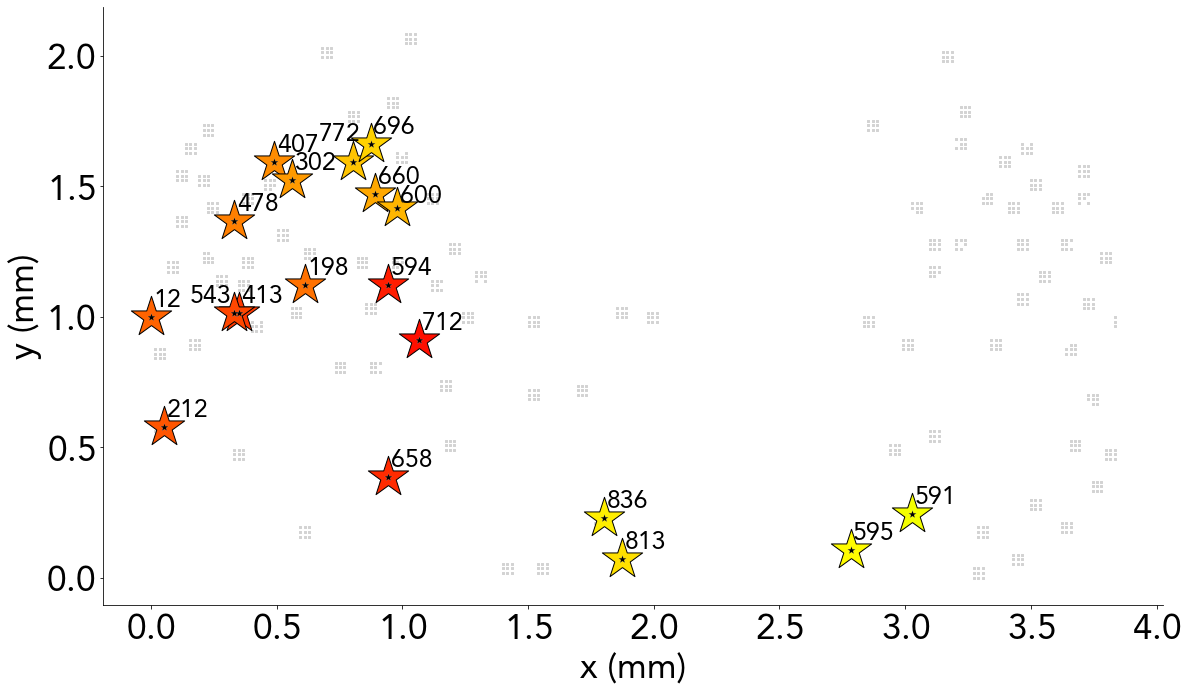

In [7]:
import seaborn as sns

# color palettes
hue_cols = sns.hls_palette(20);    hue_cols2 = sns.hls_palette(110, l=0.5, s=1)

# General parameters
dim = 60;     dim2 = 35;     size = 1800

fig, ax = plt.subplots(figsize=(19, 11))

# STIMULATION CHANNELS
a = 0
for ch in def_chans:
    label = 'stim. channels' if ch == def_chans[0] else None
    plt.scatter(pos[channel == ch, 0] / 1000, pos[channel == ch, 1] / 1000, color=hue_cols2[a], edgecolor='black', s=size, marker='*', alpha=1, zorder=1, label=label)
    a += 1

# Add a black outline to all stimulation channels
for ch in def_chans:
    plt.scatter(pos[channel == ch, 0] / 1000, pos[channel == ch, 1] / 1000, color='black', edgecolor='white', linewidths=0.1, s=70, marker='*', alpha=1, zorder=3)

# FULL MAP OF CHANNELS 
plt.scatter(pos[:, 0] / 1000, pos[:, 1] / 1000, s=8.6, marker='s', color='lightgrey',label='recording channels', zorder=0)

# LABELS FOR STIM CHANNELS 
a = 0
for ch in def_chans:
    x = pos[channel == ch, 0][0] / 1000;    y = pos[channel == ch, 1][0] / 1000
    if ch == 620:
        dx, dy = -178.5 / 1000, 40 / 1000
    elif ch == 894:
        dx, dy = -138.5 / 1000, 80 / 1000
    elif ch == 682:
        dx, dy = 10.5 / 1000, 20 / 1000
    elif ch == 328:
        dx, dy = -178.5/1000, 50/1000
    else:
        dx, dy = 10.5 / 1000, 40 / 1000
    plt.text(x + dx, y + dy, str(indices[a]),fontdict=dict(color='black', alpha=1, size=dim - dim2))
    a += 1

plt.xlabel('x (mm)', fontsize=dim2);    plt.ylabel('y (mm)', fontsize=dim2)
pl.set_format(ax, axis_ticks='both', cbar=None, DIM=dim2)
plt.savefig(path_imgs + '1_channel_map.png', bbox_inches='tight')


## 1.2 effective connectivity (EC)

TE, SC, XCov computed from 30 mins spontaneous activity.

In [8]:
_TE,  _TE_sign,  _zTE,  _zTE_sign, _TE_Pval   = lec.load_complete_measures(main_path, sim_folder, folder_prefix='ECdata_',
                                                                           file_prefix='Cult_'+str(T_spont)+'min_', 
                                                                           ECmeas = 'TE',  tp = 'pk', alpha=alpha_th)
_SC,  _SC_sign,  _zSC,  _zSC_sign, _SC_Pval   = lec.load_complete_measures(main_path, sim_folder, folder_prefix='ECdata_',
                                                                           file_prefix='Cult_'+str(T_spont)+'min_', 
                                                                           ECmeas = 'SC',  tp = 'pk', alpha=alpha_th)
_XCov,  _XCov_sign,  _zXCov,  _zXCov_sign, _XCov_Pval   = lec.load_complete_measures(main_path, sim_folder, folder_prefix='ECdata_',
                                                                                     file_prefix='Cult_'+str(T_spont)+'min_', 
                                                                                     ECmeas = 'XCov',  tp = 'pk', alpha=alpha_th)


### 1.2.1 reduce EC-matrices size

In [9]:
# (source x target) IC matrix has size: (nStimChannels, nChannels)
# To compare EC with IC - we restrict (source x target) EC matrices 
#                         from (nChannels, nChannels) to (nStimChannels, nChannels)

TE   = _TE[indices,:];  TE_sign = _TE_sign[indices,:];  zTE = _zTE[indices,:];  zTE_sign = _zTE_sign[indices,:]; TE_Pval = _TE_Pval[indices,:];
SC   = np.abs(_SC[indices,:]);  SC_sign = np.abs(_SC_sign[indices,:]);  zSC = np.abs(_zSC[indices,:]);  zSC_sign = np.abs(_zSC_sign[indices,:]); SC_Pval = _SC_Pval[indices,:];
XCov = np.abs(_XCov[indices,:]);  XCov_sign = np.abs(_XCov_sign[indices,:]);  zXCov = np.abs(_zXCov[indices,:]);  zXCov_sign = np.abs(_zXCov_sign[indices,:]); XCov_Pval = _XCov_Pval[indices,:];


## 1.3 interventional connectivity (IC)

In [10]:
ks_loading    = True   # do not change in False, because ORIGINAL DATA ARE NOT SHARED on github

if ks_loading is False:
    ks, ks_sign, ks_pval_FDR, ks_pval  = IC.compute_KS(Ntrials, def_units, def_chans, def_spikes, channel, stim_start, Delta_pre, stim_stop, Delta_post, Tmax, alpha_th=alpha_th, id_trial_start=0, n_jobs=-1, verbose=True)
    ks_bin, ks_sign_bin, ks_pval_FDR_bin, ks_pval_bin  = IC.compute_KS_binned(Ntrials, def_units, def_chans, def_spikes, channel, stim_start, Delta_pre, stim_stop, Delta_post, Tmax, Nbins=Nbins, alpha_th=alpha_th, id_trial_start=0, n_jobs=1, verbose=True)
    # store data:
    ic_save(path_IC_data, ks, ks_pval, ks_pval_FDR)
    ic_save(path_ICbin_data, ks_bin, ks_pval_bin, ks_pval_FDR_bin)
else:
    # load data
    ks, ks_pval, ks_pval_FDR = ic_load(path_IC_data)
    ks_sign     = np.copy(ks);     ks_sign[ks_pval>alpha_th] = 0
    ks_sign_FDR = np.copy(ks); ks_sign[ks_pval_FDR>alpha_th] = 0
    #==============================================#
    ks_bin, ks_pval_bin, ks_pval_FDR_bin = ic_load(path_IC_data)
    ks_sign_bin     = np.copy(ks_bin);     ks_sign_bin[ks_pval_bin>alpha_th] = 0
    ks_sign_FDR_bin = np.copy(ks_bin); ks_sign_bin[ks_pval_FDR_bin>alpha_th] = 0
    

# 2. Matrices visualization

## 2.1 before significant test

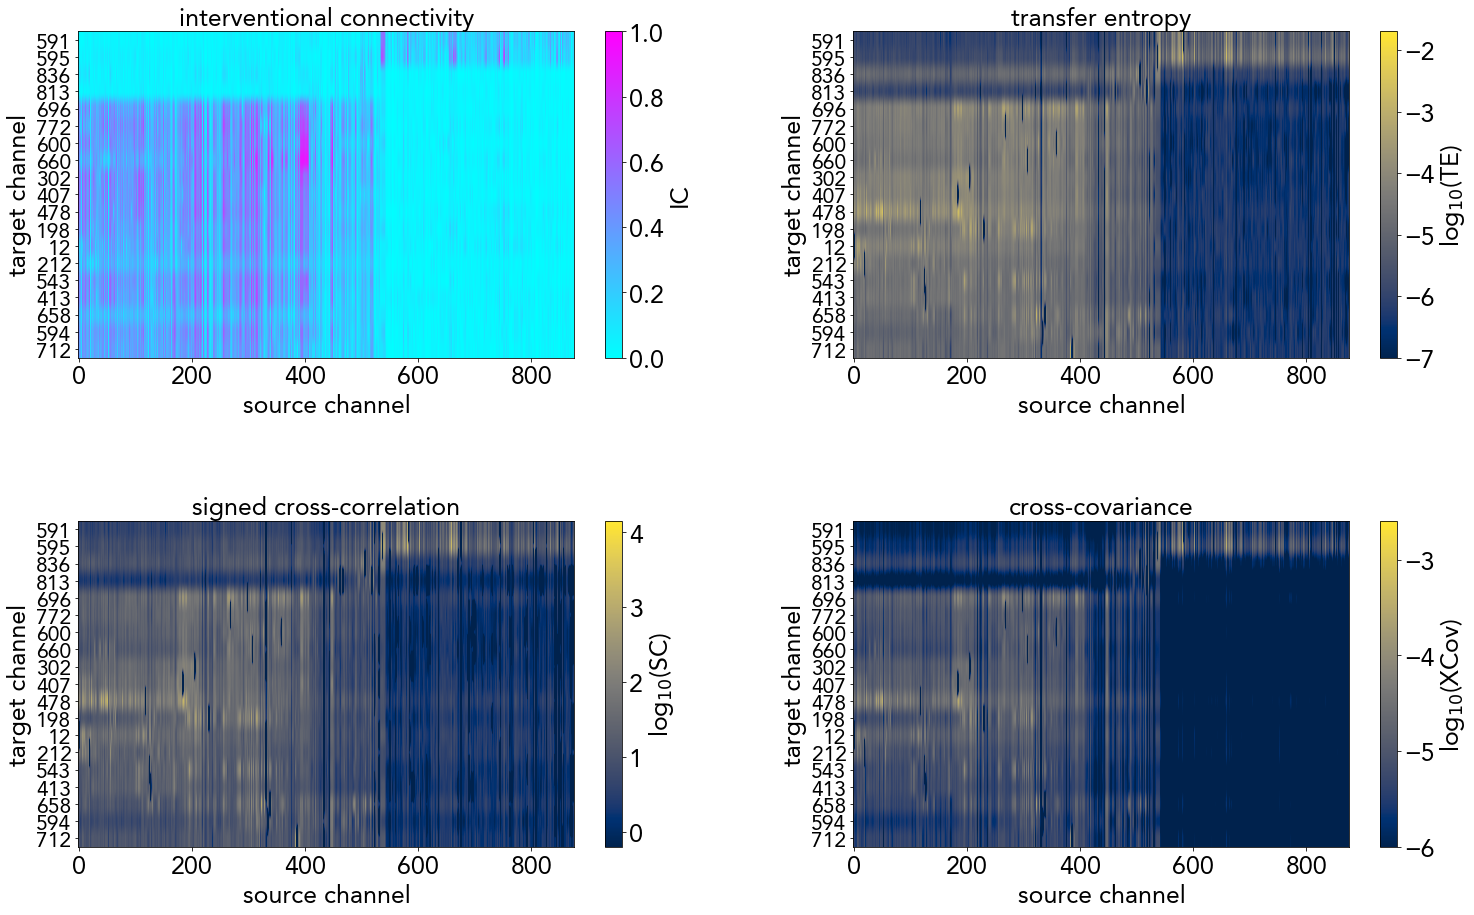

In [11]:
sort_ids = np.argsort(cluster)

fig, axs = plt.subplots(2,2,figsize=(25,15))

mat = np.copy(ks)
pl.plot_mat_aspect(mat[:,sort_ids], vmin=0,vmax=1,
                ylabel='target channel', xlabel='source channel', cbarlabel='IC', title='interventional connectivity', 
                cmap='cool', ax=axs[0,0], yticklabels=indices)

mat = np.log10(TE+1E-20)
pl.plot_mat_aspect(mat[:,sort_ids], vmin=-7,vmax=np.max(mat.flatten()),
                ylabel='target channel', xlabel='source channel', cbarlabel='log$_{10}$(TE)', title='transfer entropy', 
                cmap='cividis', ax=axs[0,1], yticklabels=indices)

mat = np.log10(SC+1E-20)
pl.plot_mat_aspect(mat[:,sort_ids], vmin=-0.2, vmax=np.max(mat.flatten()),
                ylabel='target channel', xlabel='source channel', cbarlabel='log$_{10}$(SC)', title='signed cross-correlation',
                cmap='cividis', ax=axs[1,0], yticklabels=indices)

mat = np.log10(XCov+1E-20)
pl.plot_mat_aspect(mat[:,sort_ids],  vmin=-6, vmax=np.max(mat.flatten()),
                ylabel='target channel', xlabel='source channel', cbarlabel='log$_{10}$(XCov)', title='cross-covariance',
                cmap='cividis', ax=axs[1,1], yticklabels=indices)

fig.subplots_adjust(wspace=0.25, hspace=0.5)

plt.savefig(path_imgs + '2_IC_EC_matrices.png', bbox_inches='tight')


## 2.2 after significant test

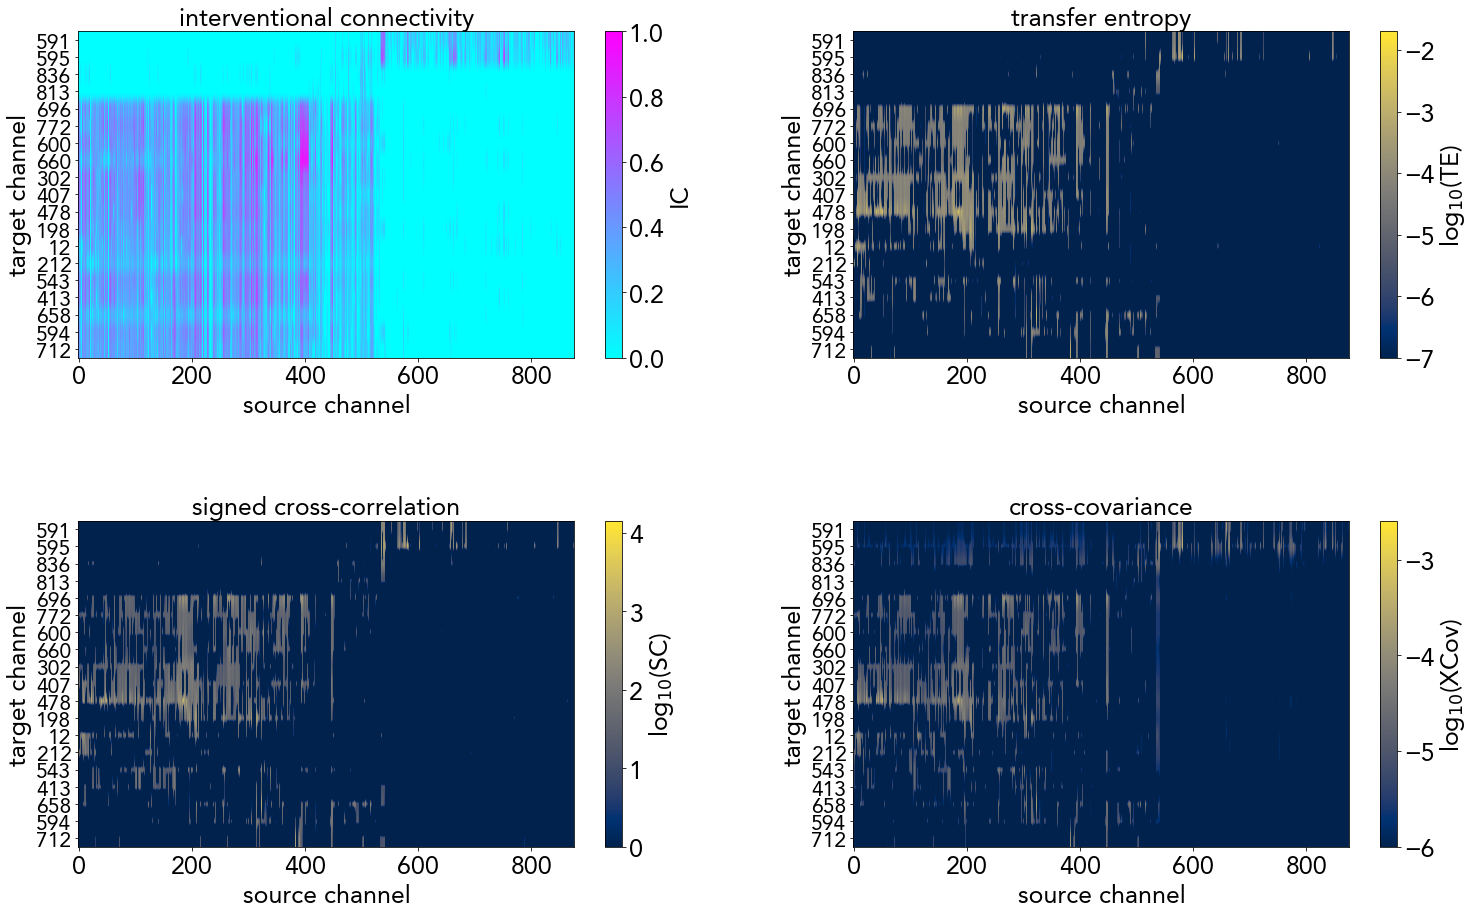

In [12]:
sort_ids = np.argsort(cluster)

fig, axs = plt.subplots(2,2,figsize=(25,15))

mat = np.copy(ks_sign)
pl.plot_mat_aspect(mat[:,sort_ids], vmin=0,vmax=1,
                ylabel='target channel', xlabel='source channel', cbarlabel='IC', title='interventional connectivity', 
                cmap='cool', ax=axs[0,0], yticklabels=indices)

mat = np.log10(TE_sign+1E-20)
pl.plot_mat_aspect(mat[:,sort_ids], vmin=-7,vmax=np.max(mat.flatten()),
                ylabel='target channel', xlabel='source channel', cbarlabel='log$_{10}$(TE)', title='transfer entropy', 
                cmap='cividis', ax=axs[0,1], yticklabels=indices)

mat = np.log10((SC_sign)+1E-20)
pl.plot_mat_aspect(mat[:,sort_ids], vmin=-0, vmax=np.max(mat.flatten()),
                ylabel='target channel', xlabel='source channel', cbarlabel='log$_{10}$(SC)', title='signed cross-correlation',
                cmap='cividis', ax=axs[1,0], yticklabels=indices)

mat = np.log10((XCov_sign)+1E-20)
pl.plot_mat_aspect(mat[:,sort_ids],  vmin=-6, vmax=np.max(mat.flatten()),
                ylabel='target channel', xlabel='source channel', cbarlabel='log$_{10}$(XCov)', title='cross-covariance',
                cmap='cividis', ax=axs[1,1], yticklabels=indices)

fig.subplots_adjust(wspace=0.25, hspace=0.5)

plt.savefig(path_imgs + '2_IC_EC_matrices_SIGN.png', bbox_inches='tight')


# 3. IC vs. EC – depending on recording time

## 3.1 whole matrices

In [13]:
# Whole matrix
rec_T = np.array([5,10,15,20,25,30])

correlations = np.zeros((len(rec_T),6))
i_T=0
for DeltaT in rec_T:
    EC_mat, EC_lab, EC_save = lec.load_matrices(main_path, sim_folder, binsize=0.3, 
                                            file_prefix='Cult_'+str(DeltaT)+'min_')
    for idx_meas in range(len(EC_mat)):
        IC_v = ks.flatten()
        EC_v = EC_mat[idx_meas][indices,:].flatten()
        correlations[i_T,idx_meas] = np.round(spearmanr(IC_v,EC_v),2)[0]
    i_T+=1


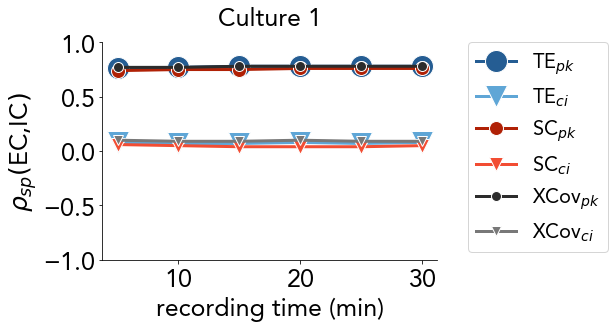

In [14]:
fig,ax = plt.subplots()
style=['o-','v-','o-','v-','o-','v-']
mc = ['white','white','white','white','white','white']
sizez=[22,22,14,14,10,10]
for idx_meas in range(len(EC_mat)):
    ax.plot(rec_T,correlations[:,idx_meas],style[idx_meas],color=colorz[idx_meas],markeredgewidth=1,
            markeredgecolor=mc[idx_meas], markersize=sizez[idx_meas], lw=3,label=EC_lab[idx_meas],alpha=1)
ax.set_ylim(-1,1)
ax.set_xlabel('recording time (min)')
ax.set_ylabel(r'$\rho_{{sp}}($EC,IC$)$')
ax.legend(ncol=1,fontsize=20,bbox_to_anchor=(1.3, 1.), loc='upper center', borderaxespad=0.)

pl.set_format(ax, axis_ticks = 'both', pwr_x_min=-1, pwr_x_max=2, pwr_y_min=-1, pwr_y_max=1, 
              cbar = None, pwr_cbar_min=-1, pwr_cbar_max=1,  DIM = DIM)

xt=ax.set_title('Culture 1',fontsize=DIM,y=1.05)
plt.savefig(path_imgs + '3.1_sampleSize_ECrecAcc.png', bbox_inches='tight')


## 3.2 IC vs EC – for fixed source channel 

In [15]:
# Recording durations
rec_T = np.array([5,10,15,20,25,30])

# Source nodes
correlations = {}
for idx_meas in range(6):
    correlations[idx_meas] = np.zeros((len(rec_T),len(indices)))

i_T=0
for DeltaT in rec_T:
    EC_mat, EC_lab, EC_save = lec.load_matrices(main_path, sim_folder, binsize=0.3, file_prefix='Cult_'+str(DeltaT)+'min_')
    for idx_meas in range(len(EC_mat)):
        j_idx=0
        for idx in indices:
            IC_v = ks[j_idx,:].flatten(); EC_v = EC_mat[idx_meas][idx,:].flatten()
            correlations[idx_meas][i_T,j_idx] = np.round(spearmanr(IC_v,EC_v),2)[0]
            j_idx+=1
    i_T+=1

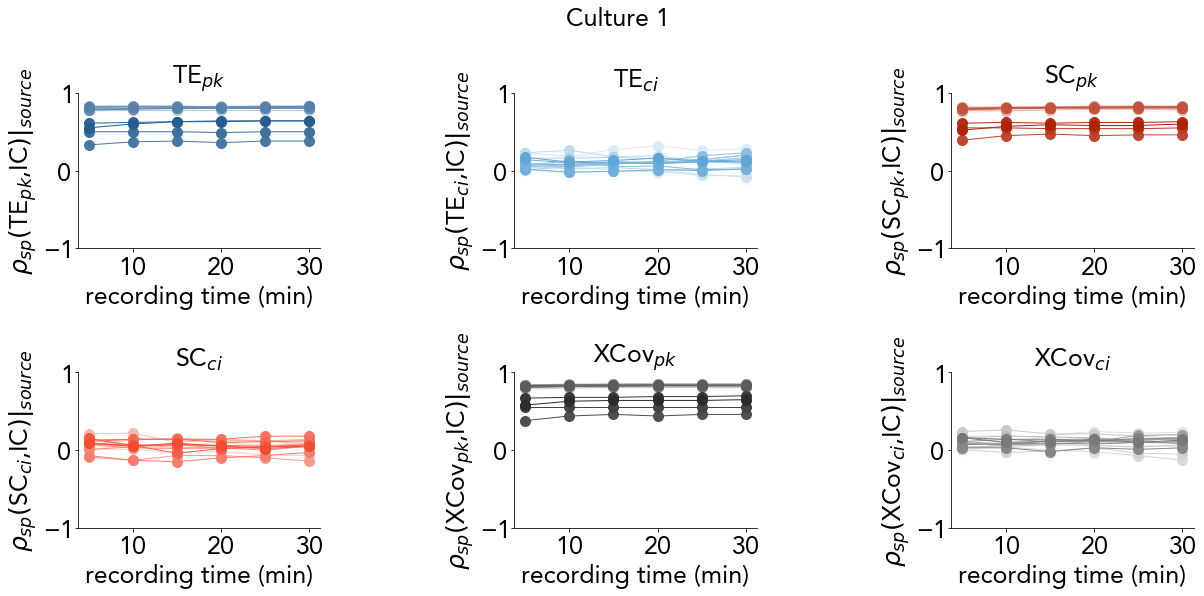

In [17]:
fig,axs = plt.subplots(2,3,figsize=(20,8))
a=0
for idx_meas in range(len(EC_mat)):
    color_gradient = pl.get_color_gradient(0, len(indices), colorz[idx_meas])
    ax = axs[a//3,a%3]
    for i in range(len(indices)):
        ax.plot(rec_T,correlations[idx_meas][:,i],'o-',color = color_gradient[i], 
                markersize=10, lw=1, alpha=1)
        ax.set_ylim(-1,1)
        ax.set_xlabel('recording time (min)')
        ax.set_ylabel(r'$\rho_{{sp}}($'+EC_lab[idx_meas]+',IC$)|_{source}$')
        ax.set_title(EC_lab[idx_meas])
    pl.set_format(ax, axis_ticks = 'both', pwr_x_min=-1, pwr_x_max=2, pwr_y_min=-1, pwr_y_max=1, 
              cbar = None, pwr_cbar_min=-1, pwr_cbar_max=1,  DIM = DIM)
    a+=1
fig.subplots_adjust(wspace=0.8,hspace=0.8)
xt=fig.suptitle('Culture 1',fontsize=DIM,y=1.03)
plt.savefig(path_imgs + '3.2_sampleSize_ECrecAcc_source.png', bbox_inches='tight')


## 3.3 EC$_{30\, min}$ vs EC of other durations – for fixed source channel

In [18]:
# Recording durations
rec_T = np.array([5,10,15,20,25,30])

# Source nodes
correlations = {}
for idx_meas in range(6):
    correlations[idx_meas] = np.zeros((len(rec_T),len(indices)))

max_EC_mat, _, _ = lec.load_matrices(main_path, sim_folder, binsize=0.3, file_prefix='Cult_'+str(rec_T[-1])+'min_')

i_T=0
for DeltaT in rec_T:
    EC_mat, EC_lab, EC_save = lec.load_matrices(main_path, sim_folder, binsize=0.3, file_prefix='Cult_'+str(DeltaT)+'min_')
    for idx_meas in range(len(EC_mat)):
        j_idx=0
        for idx in indices:
            EC_Tmax = max_EC_mat[idx_meas][idx,:].flatten()
            EC_v = EC_mat[idx_meas][idx,:].flatten()
            correlations[idx_meas][i_T,j_idx] = np.round(spearmanr(EC_Tmax,EC_v),2)[0]
            j_idx+=1
    i_T+=1


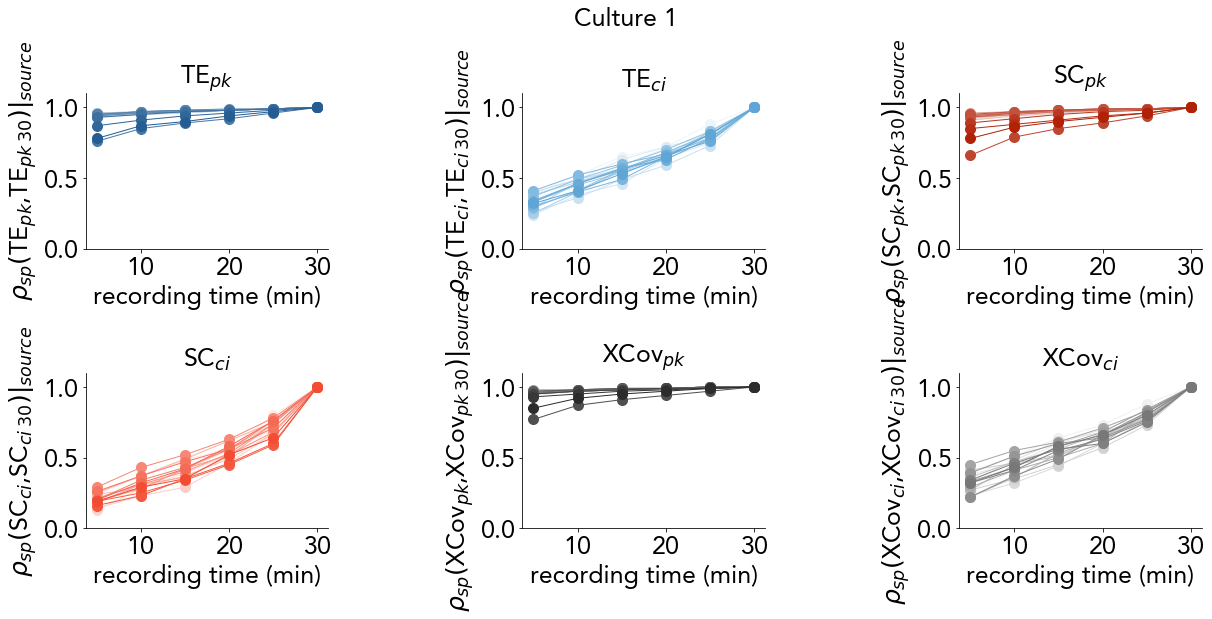

In [19]:
fig,axs = plt.subplots(2,3,figsize=(20,8))
a=0
for idx_meas in range(len(EC_mat)):
    color_gradient = pl.get_color_gradient(0, len(indices), colorz[idx_meas])
    ax = axs[a//3,a%3]
    for i in range(len(indices)):
        ax.plot(rec_T,correlations[idx_meas][:,i],'o-',color = color_gradient[i], 
                markersize=10, lw=1, alpha=1)
        ax.set_ylim(0,1.1)
        ax.set_xlabel('recording time (min)')
        ax.set_ylabel(r'$\rho_{{sp}}($'+EC_lab[idx_meas]+','+EC_lab[idx_meas]+'$_{\,30})|_{source}$')
        ax.set_title(EC_lab[idx_meas])
    pl.set_format(ax, axis_ticks = 'both', pwr_x_min=-1, pwr_x_max=2, pwr_y_min=-1, pwr_y_max=1, 
              cbar = None, pwr_cbar_min=-1, pwr_cbar_max=1,  DIM = DIM)
    a+=1
fig.subplots_adjust(wspace=0.8,hspace=0.8)
xt=fig.suptitle('Culture 1',fontsize=DIM,y=1.03)
plt.savefig(path_imgs + '3.3_sampleSize_ECsim_source.png', bbox_inches='tight')


# 4. EC-IC similarity



## 4.1 Whole matrices

Reconstruction accuracies calculated on full IC-EC matrices (left column in the matrix), as well as in-strength (central column) and out-strength (right column) distributions.

In [20]:
mats = [TE, SC, XCov]
labs = ['TE','SC','XCov']

Scorr, Pcorr         = cc.corrMeasures(mats, ks, indices, compute_strength=False)
Scorr_in, Pcorr_in   = cc.corrMeasures(mats, ks, indices, compute_strength=True)
Scorr_out, Pcorr_out = cc.corrMeasures_outStr(mats,  ks, indices)

Scorr_all = np.vstack([Scorr, Scorr_in, Scorr_out])
Pcorr_all = np.vstack([Pcorr, Pcorr_in, Pcorr_out])

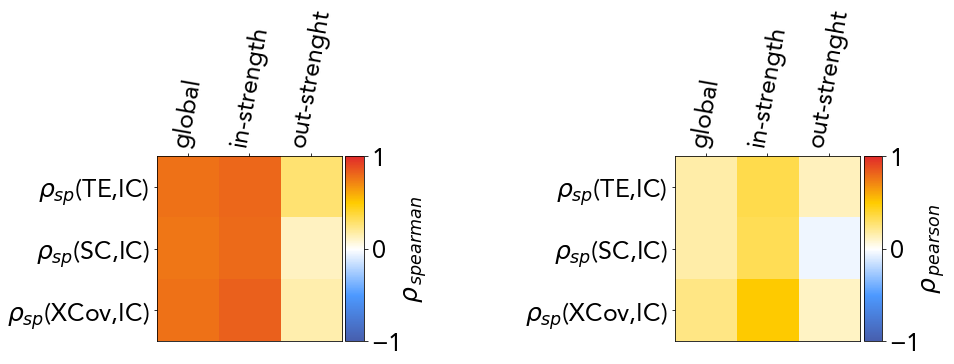

In [21]:
fig,axs = plt.subplots(1,2,figsize=(13,4.5))

cc.plot_corr_matrix(Scorr_all.T,labs,r'$\rho_{{\,spearman}}$', ax=axs[0])
cc.plot_corr_matrix(Pcorr_all.T,labs,r'$\rho_{{\,pearson}}$', ax=axs[1])
fig.subplots_adjust(wspace=1.5, hspace=0.5)

plt.savefig(path_imgs + '4.1_ECrecAcc_wholeMats.png', bbox_inches='tight')


## 4.2 surce channel fixed

<br>
Reconstruction accuracy ($\rho_{spearman}$ and $\rho_{pearson}$) for all source electrodes, comparing IC to each EC measure (TE, SC and XCov - pk version).

In [23]:
mats = [TE, SC, XCov]
labs = ['TE','SC','XCov']

spearman, spearman_p = cc.correlate_source_fixed(mats, ks, exclude_zeros=False)
cpearson, cpearson_p = cc.correlate_source_fixed(mats, ks, exclude_zeros=False, pearson=True)


 
<br>
Here, each curve is referred one metric and is sorted to ensure a monotonic increase in accuracy values.

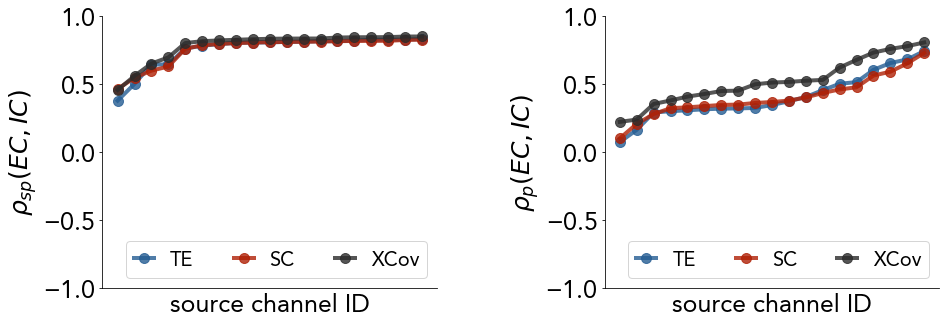

In [24]:
fig,axs = plt.subplots(1,2,figsize=(15,5))
cc.plot_correlations(spearman, labs, ylabel=r'$\rho_{sp}(EC,IC)$', ax=axs[0]) # spearman
cc.plot_correlations(cpearson, labs, ylabel=r'$\rho_{p}(EC,IC)$',  ax=axs[1])  # pearson
fig.subplots_adjust(wspace=0.5, hspace=0.5)
plt.savefig(path_imgs + '4.2_ECrecAcc_source.png', bbox_inches='tight')


<br>
For visualization, correlation between EC and IC for every fixed source channel is represented as a matrix. Each row is referred one metric.

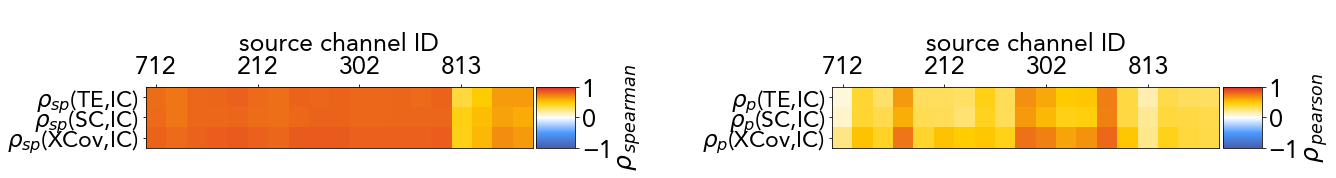

In [25]:
fig,axs = plt.subplots(1,2,figsize=(20,5))
cc.plot_corr_elements(spearman, labs, indices, r' ', ax=axs[0]) # spearman
cc.plot_corr_elements(cpearson, labs, indices,  r' ', label=r'$\rho_{{\,pearson}}$',pearson=True, ax=axs[1]) # pearson
fig.subplots_adjust(wspace=0.6, hspace=0.5)
plt.savefig(path_imgs + '4.2_ECrecAcc_source_2.png', bbox_inches='tight')


## 4.3 data-split validation

### 4.3 split the trials in 2 and compute 2 IC matrices

In [26]:
# split the trials in 2 (you can do the same with ks_bin)

ks_loading    = True    # do not change in False, because ORIGINAL DATA ARE NOT SHARED on github
if ks_loading is False: #compute and store fdata
    ks_split1, ks_sign_split1, ks_pval_FDR_split1, ks_pval_split1  = IC.compute_KS(100, def_units, def_chans, def_spikes, channel,stim_start, Delta_pre, stim_stop, Delta_post, Tmax,
                                                    alpha_th=alpha_th, id_trial_start=0, n_jobs=-1, verbose=False)
    ic_save(path_IC_data, ks_split1, ks_pval_split1, ks_pval_FDR_split1, suffix='_split1')
    #==============================================#
    ks_split2, ks_sign_split2, ks_pval_FDR_split2, ks_pval_split2  = IC.compute_KS(200, def_units, def_chans, def_spikes, channel,stim_start, Delta_pre, stim_stop, Delta_post, Tmax,
                                                    alpha_th=alpha_th, id_trial_start=100, n_jobs=-1, verbose=False)
    ic_save(path_IC_data, ks_split2, ks_pval_split2, ks_pval_FDR_split2, suffix='_split2')


else:                   # load data
    ks_split1, ks_pval_split1, ks_pval_FDR_split1 = ic_load(path_IC_data,suffix='_split1')
    ks_sign_split1     = np.copy(ks_split1);     ks_sign_split1[ks_pval_split1>alpha_th] = 0
    ks_sign_FDR_split1 = np.copy(ks_split1); ks_sign_split1[ks_pval_FDR_split1>alpha_th] = 0
    #==============================================#
    ks_split2, ks_pval_split2, ks_pval_FDR_split2 = ic_load(path_IC_data,suffix='_split2')    
    ks_sign_split2     = np.copy(ks_split2);     ks_sign_split2[ks_pval_split2>alpha_th] = 0
    ks_sign_FDR_split2 = np.copy(ks_split2); ks_sign_split2[ks_pval_FDR_split2>alpha_th] = 0



In [27]:
# compute IC-EC correlations

spearman_cross1, spearman_p_cross1 = cc.correlate_source_fixed(mats, ks_split1, exclude_zeros=False)
cpearson_cross1, cpearson_p_cross1 = cc.correlate_source_fixed(mats, ks_split1, exclude_zeros=False, pearson=True)

spearman_cross2, spearman_p_cross1 = cc.correlate_source_fixed(mats, ks_split2, exclude_zeros=False)
cpearson_cross2, cpearson_p_cross1 = cc.correlate_source_fixed(mats, ks_split2, exclude_zeros=False, pearson=True)

In [28]:
def plot_correlations_cv(corr_mat, corr_mat2, corr_mat3, label, color='blue', pearson=False, marker='X-', 
                         markersize=12, figsize=(5, 4), ax=None, outf : str = None, show_plot = False):

    if ax is None:
        fig,ax = plt.subplots(figsize=figsize)
    else:
        fig = ax.get_figure() 
    
    L = np.argsort(corr_mat)
    line, = ax.plot(corr_mat[L], marker, markersize=markersize, color=color, label=label, lw=3, alpha=1)
    
    L = np.argsort(corr_mat2)
    line, = ax.plot(corr_mat2[L], '-', color='crimson', label='validation set 1', lw=2, alpha=1)
    
    L = np.argsort(corr_mat3)
    line, = ax.plot(corr_mat3[L], '--.', color='orange', label='validation set 2', lw=2, alpha=1)
    
    ax.set_xlabel('source channel ID\n'+r'$_{sorted\,\,by\,\,\rho}$', fontsize=DIM)
    if pearson==False:
        ax.set_ylabel(r'$\rho_{sp}(EC,IC)\,|_{source\, fixed}$', fontsize=DIM)
    else:
        ax.set_ylabel(r'$\rho_{p}(EC,IC)\,|_{source\, fixed}$', fontsize=DIM)
    ax.set_ylim(-1, 1)
    
    ax.legend(fontsize=DIM-5, ncol=1, handlelength=1)
    ax.set_xticks([])
    pl.set_format(ax, axis_ticks = 'both', DIM = DIM)
    
    if ax is None:
        if outf:
            ax.savefig(outf, bbox_inches='tight')
            if not show_plot:
                plt.close()
        else:
            plt.show()

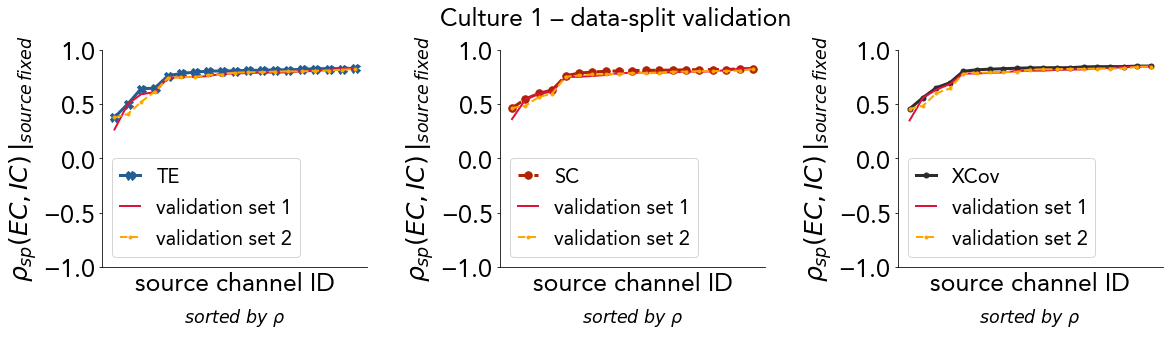

In [29]:
colors_dl = ['#255D93', '#5FA6D6', '#B02106', '#F24D33', '#2C2C2C', '#787878']
fig,axs = plt.subplots(1,3,figsize=(19,4))
cc.plot_correlations_cv(spearman[0], spearman_cross1[0], spearman_cross2[0], 'TE',   color=colors_dl[0], pearson=False, marker='X-', markersize=9, ax=axs[0])
cc.plot_correlations_cv(spearman[1], spearman_cross1[1], spearman_cross2[1], 'SC',   color=colors_dl[2], pearson=False, marker='.--', markersize=15, ax=axs[1])
cc.plot_correlations_cv(spearman[2], spearman_cross1[2], spearman_cross2[2], 'XCov', color=colors_dl[4], pearson=False, marker='.-', markersize=10, ax=axs[2])
fig.subplots_adjust(wspace=0.5,hspace=0.5)
xt=fig.suptitle('Culture 1 – data-split validation',fontsize=DIM,y=1.03)
plt.savefig(path_imgs + '4.3_data-split_validation.png', bbox_inches='tight')


## 4.4 scatterplots EC-IC (whole matrices)

Scatter plots of IC vs. TE, SC, and XCov (non-z-scored), built by flattening each matrix

In [30]:
def truncate_cmap(cmap, minval=0.0, maxval=0.8, n=256):
    from matplotlib.colors import Normalize, LinearSegmentedColormap
    return LinearSegmentedColormap.from_list( f'{cmap.name}_trunc', cmap(np.linspace(minval, maxval, n)) )


### 4.4.1 linear scale

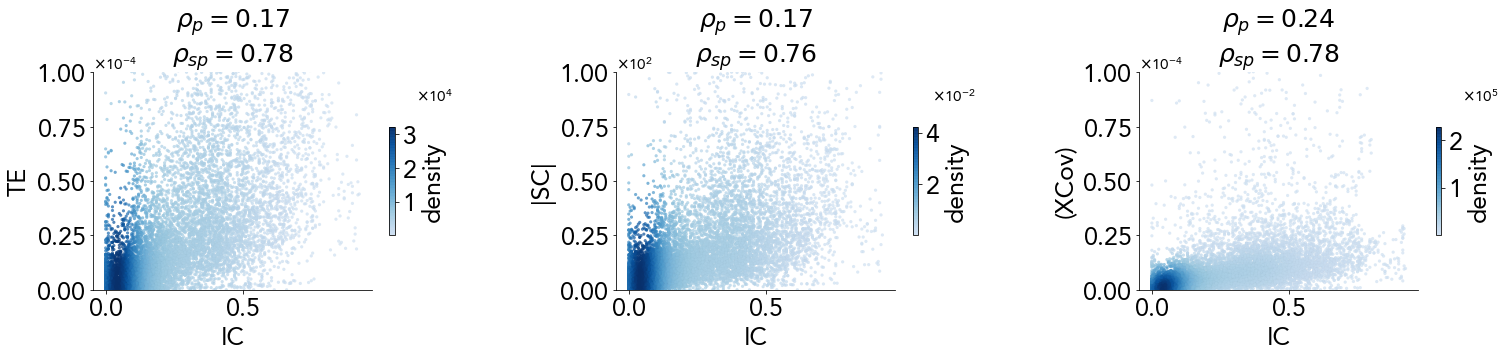

In [31]:
fig,axs=plt.subplots(1,3,figsize=(25,4)); cmap=truncate_cmap(plt.get_cmap('Blues'), minval=0.2, maxval=1)
pl.plot_scatter(ks, TE,   -11, ylabel='TE',    dotsize=10, edgecolor='grey', linewidths=0.01, reg_line=False, log=False, ymin=0, ymax=1E-4, ax = axs[0], regcolor='k', cmap=cmap)
pl.plot_scatter(ks, SC,   -2,  ylabel='|SC|',  dotsize=10, edgecolor='grey', linewidths=0.01, reg_line=False, log=False, ymin=0, ymax=1E2,  ax = axs[1], regcolor='k', cmap=cmap)
pl.plot_scatter(ks, XCov, -11, ylabel='(XCov)',dotsize=10, edgecolor='grey', linewidths=0.01, reg_line=False, log=False, ymin=0, ymax=1E-4, ax = axs[2], regcolor='k', cmap=cmap)
fig.subplots_adjust(wspace=0.5, hspace=0.5)
plt.savefig(path_imgs + '4.4.1_wholeMat_scatter-lin.png', bbox_inches='tight')


### 4.4.2 log scale

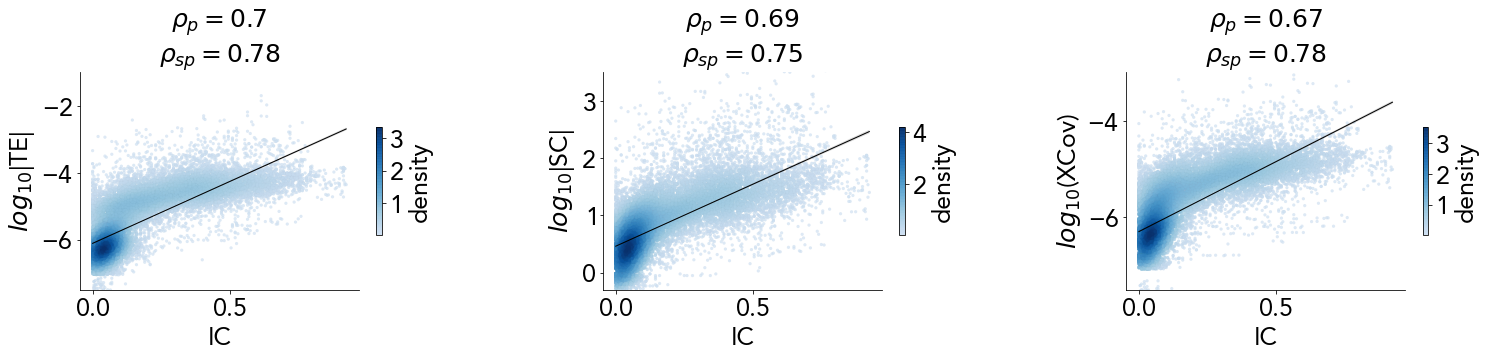

In [32]:
fig,axs=plt.subplots(1,3,figsize=(25,4))
pl.plot_scatter(ks, TE,   -11, ylabel='$log_{10}$|TE|',  ymin=-7.5, ymax=-1, dotsize=10, log=True, ax = axs[0], edgecolor='grey', linewidths=0.01, regcolor='k', cmap=cmap)
pl.plot_scatter(ks, SC,   -2,  ylabel='$log_{10}$|SC|',  ymin=-0.3, ymax=3.5,dotsize=10, log=True, ax = axs[1], edgecolor='grey', linewidths=0.01, regcolor='k', cmap=cmap)
pl.plot_scatter(ks, XCov, -11, ylabel='$log_{10}$(XCov)',ymin=-7.5, ymax=-3, dotsize=10, log=True, ax = axs[2], edgecolor='grey', linewidths=0.01, regcolor='k', cmap=cmap)
fig.subplots_adjust(wspace=0.5, hspace=0.5)
plt.savefig(path_imgs + '4.4.2_wholeMat_scatter-log.png', bbox_inches='tight')


### 4.4.3 sign matrices – log scale

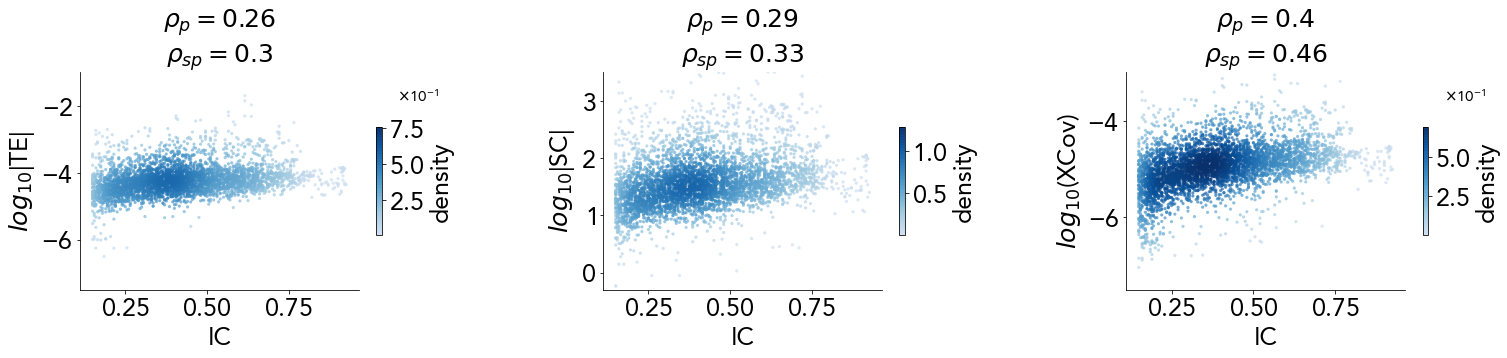

In [59]:
# EC vs. IC in correspondence of sign. IC links
fig,axs=plt.subplots(1,3,figsize=(25,4))
pl.plot_scatter(ks_sign[ks_sign!=0],   TE_sign[ks_sign!=0], -11, ylabel='$log_{10}$|TE|',   ymin=-7.5, ymax=-1,  dotsize=10, edgecolor='grey', linewidths=0.01, reg_line=False, log=True, ax = axs[0], regcolor='k', cmap=cmap)
pl.plot_scatter(ks_sign[ks_sign!=0],   SC_sign[ks_sign!=0],  -2, ylabel='$log_{10}$|SC|',   ymin=-0.3, ymax=3.5, dotsize=10, edgecolor='grey', linewidths=0.01, reg_line=False, log=True, ax = axs[1], regcolor='k', cmap=cmap)
pl.plot_scatter(ks_sign[ks_sign!=0], XCov_sign[ks_sign!=0], -11, ylabel='$log_{10}$(XCov)', ymin=-7.5, ymax=-3,  dotsize=10, edgecolor='grey', linewidths=0.01, reg_line=False, log=True, ax = axs[2], regcolor='k', cmap=cmap)
fig.subplots_adjust(wspace=0.5, hspace=0.5)


## 4.5 EC-IC scatterplots – similarity for fixed source channel

Scatter plots of IC vs. TE, SC, and XCov (non-z-scored) for different source channels, illustrating a strong positive correlation.

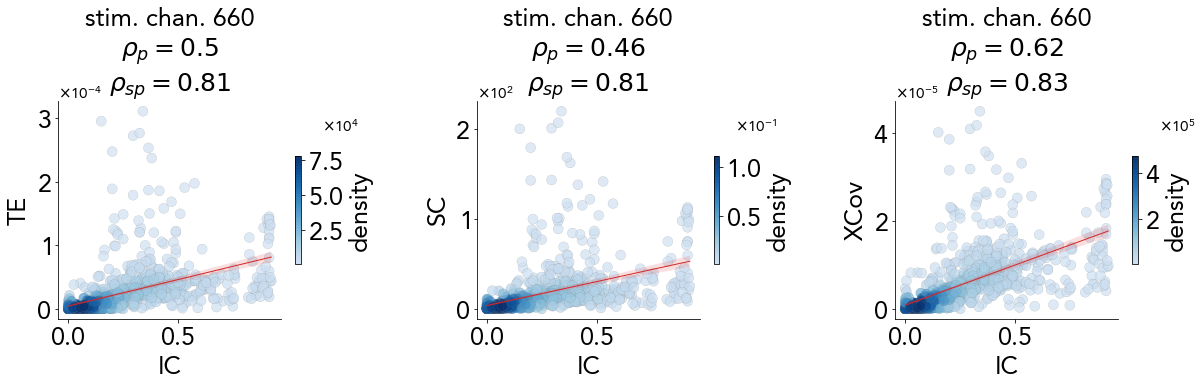

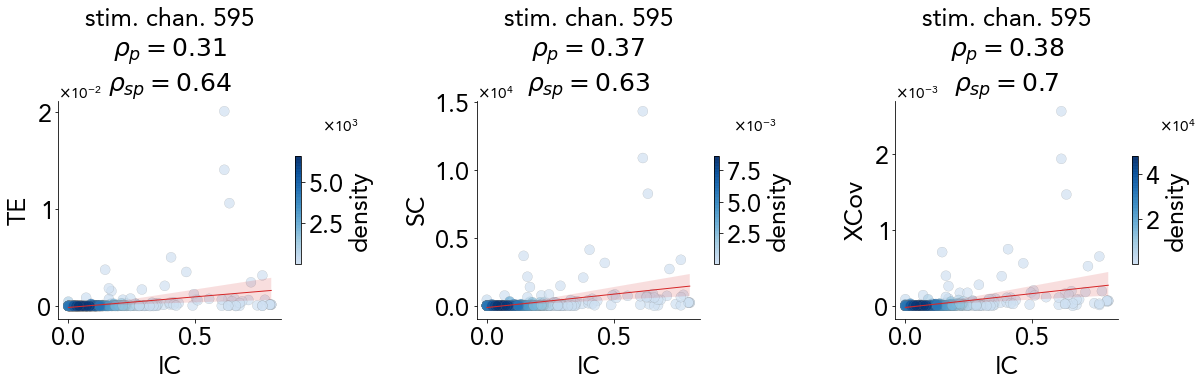

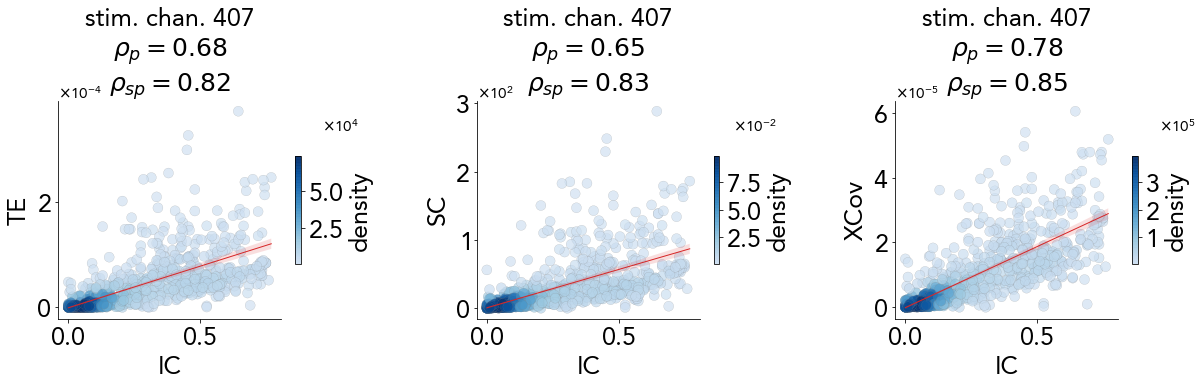

In [33]:
list_idxs = [660,595,407] # These are three of the stimulating channels in indices (the ones shown in the paper).
                          # Extend to for i in len(indices) to see the scatter plots for every stim. channel.
                          # Note: Stim. channels are named as idxs and not as channel IDs, 
                          #       You can obtain the channel-IDs with: channel[indices]
for idx in list_idxs:
    i = np.where(indices==idx)[0][0] # 601 for culture 2
    fig,axs=plt.subplots(1,3,figsize=(20,4))
    pl.plot_scatter(ks[i,:], TE[i,:],   -11, ylabel='TE',   dotsize=100, regcolor='tab:red', cmap=cmap, 
                 edgecolor='grey', linewidths=0.2, title=f'stim. chan. {indices[i]}', ax = axs[0])
    pl.plot_scatter(ks[i,:], SC[i,:],   -2,  ylabel='SC',   dotsize=100, regcolor='tab:red', cmap=cmap, 
                 edgecolor='grey', linewidths=0.2, title=f'stim. chan. {indices[i]}', ax = axs[1])
    pl.plot_scatter(ks[i,:], XCov[i,:], -11, ylabel='XCov', dotsize=100, regcolor='tab:red', cmap=cmap, 
                 edgecolor='grey', linewidths=0.2, title=f'stim. chan. {indices[i]}', ax = axs[2])
    fig.subplots_adjust(wspace=0.5, hspace=0.5)
    
    plt.savefig(path_imgs + f'4.5_source_scatter_{indices[i]}.png', bbox_inches='tight')


# 5. Barplots

- Mean EC values for source-target pairs grouped by whether their IC effect is significant (right bar in each pair) or not (left bar).
- Mean IC values for source-target pairs grouped by whether their EC link is significant (right bar in each pair) or not (left bar).


Error bars represent the standard error of the mean (s.e.m.). 

A permutation test is applied for significativity, with null ipothesis that the mean values of the two bars were identical. <br>
Asterisks $*$, $**$, $***$ indicate significance levels of $p < 0.05$, $0.01$, and $0.001$, respectively.

## 5.1 Whole matrices

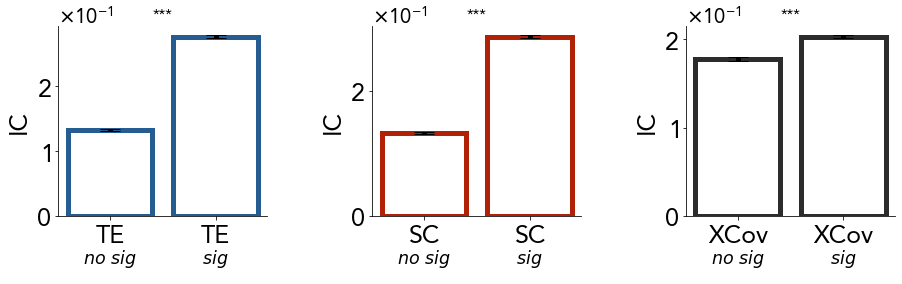

In [34]:
fig,axs=plt.subplots(1,3,figsize=(15,3.5))
pl.plot_bars(ks, TE,   'IC', 'TE',   TE_Pval,   colorz[0], colBar='black', doubleP=True, alpha_th = 0.001, ax=axs[0])
pl.plot_bars(ks, SC,   'IC', 'SC',   SC_Pval,   colorz[2], colBar='black', doubleP=True, alpha_th = 0.001, ax=axs[1])
pl.plot_bars(ks, XCov, 'IC', 'XCov', XCov_Pval, colorz[4], colBar='black', doubleP=True, alpha_th = 0.001, ax=axs[2])
fig.subplots_adjust(wspace=0.5, hspace=0.5)
plt.savefig(path_imgs + '5.1.1_wholeMat_bar.png', bbox_inches='tight')


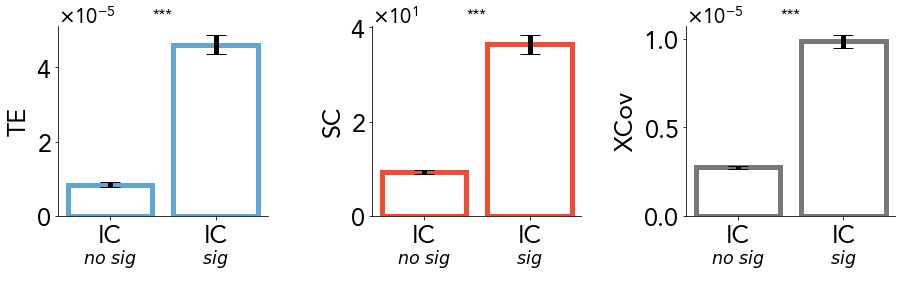

In [35]:
fig,axs=plt.subplots(1,3,figsize=(15,3.5))
pl.plot_bars(TE,   ks, 'TE',  'IC',  ks_pval, colorz[1], colBar='black', doubleP=True, alpha_th = 0.05, ax=axs[0])
pl.plot_bars(SC,   ks, 'SC',  'IC',  ks_pval, colorz[3], colBar='black', doubleP=True, alpha_th = 0.05, ax=axs[1])
pl.plot_bars(XCov, ks, 'XCov','IC',  ks_pval, colorz[5], colBar='black', doubleP=True, alpha_th = 0.05, ax=axs[2])
fig.subplots_adjust(wspace=0.5, hspace=0.5)
plt.savefig(path_imgs + '5.1.2_wholeMat_bar.png', bbox_inches='tight')


## 5.2 Fixed source channel

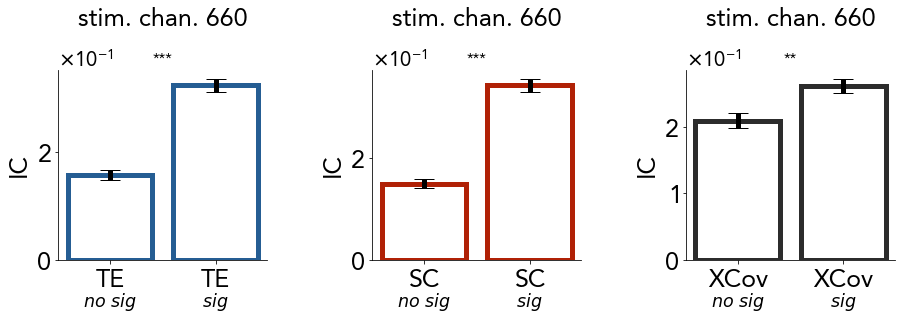

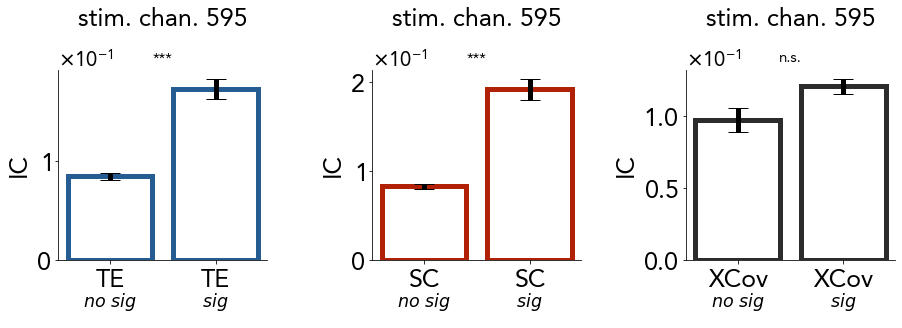

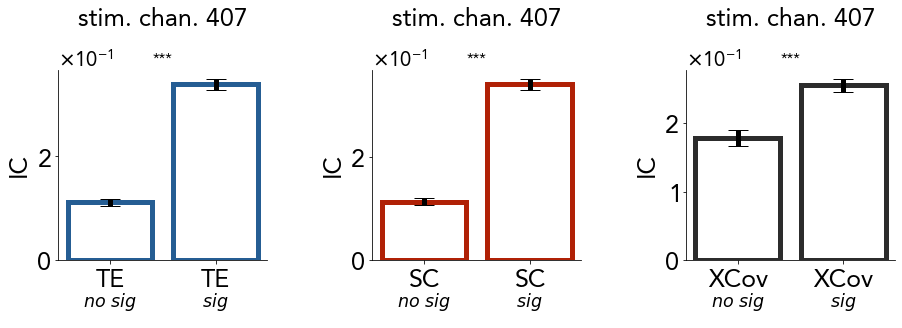

In [36]:
list_idxs = [660,595,407] # These are three of the stimulating channels in indices (the ones shown in the paper).
                          # Extend to for i in len(indices) to see the scatter plots for every stim. channel.
                          # Note: Stim. channels are named as idxs and not as channel IDs, 
                          #       You can obtain the channel-IDs with: channel[indices]
for idx in list_idxs:
    i = np.where(indices==idx)[0][0] # 601 for culture 2

    fig,axs=plt.subplots(1,3,figsize=(15,3.5))
    pl.plot_bars(ks[i,:], TE[i,:],   'IC', 'TE',   TE_Pval[i,:],   colorz[0], title=f'stim. chan. {indices[i]}', colBar='black', doubleP=True, alpha_th = 0.001, ax=axs[0])
    pl.plot_bars(ks[i,:], SC[i,:],   'IC', 'SC',   SC_Pval[i,:],   colorz[2], title=f'stim. chan. {indices[i]}', colBar='black', doubleP=True, alpha_th = 0.001, ax=axs[1])
    pl.plot_bars(ks[i,:], XCov[i,:], 'IC', 'XCov', XCov_Pval[i,:], colorz[4], title=f'stim. chan. {indices[i]}', colBar='black', doubleP=True, alpha_th = 0.001, ax=axs[2])
    fig.subplots_adjust(wspace=0.5, hspace=0.5)
    plt.savefig(path_imgs + f'5.2.1_source_bar_{indices[i]}.png', bbox_inches='tight')
    

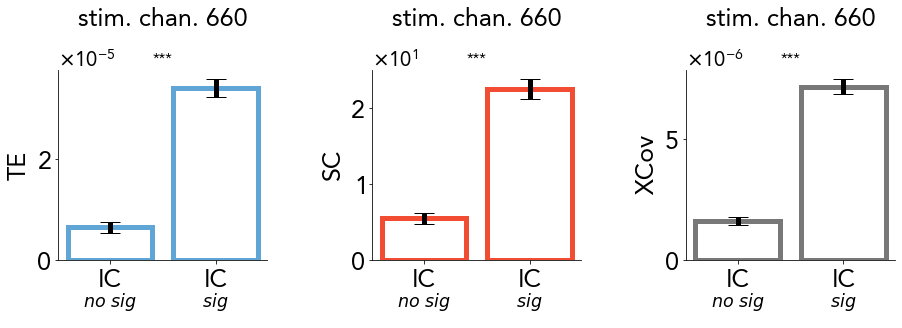

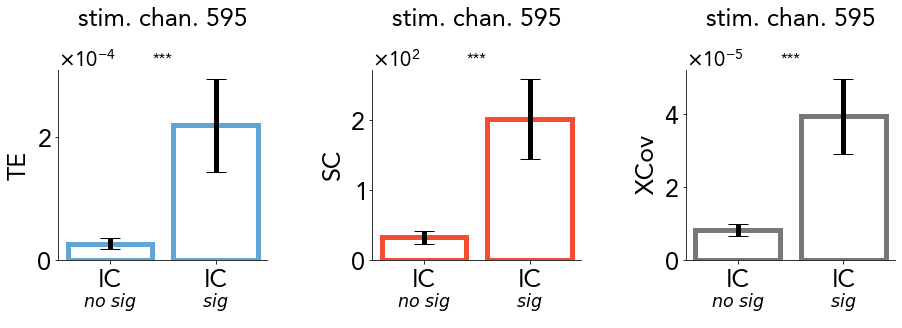

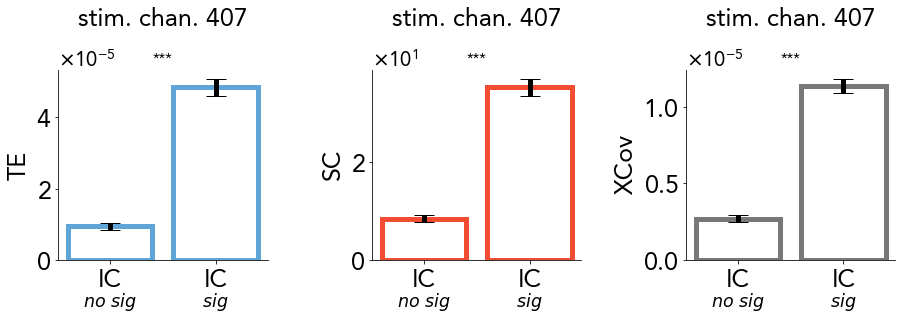

In [37]:
list_idxs = [660,595,407]
for idx in list_idxs:
    i = np.where(indices==idx)[0][0]

    fig,axs=plt.subplots(1,3,figsize=(15,3.5))
    pl.plot_bars(TE[i,:],   ks[i,:], 'TE',  'IC',  ks_pval[i,:], colorz[1], title=f'stim. chan. {indices[i]}', colBar='black', doubleP=True, alpha_th = 0.001, ax=axs[0])
    pl.plot_bars(SC[i,:],   ks[i,:], 'SC',  'IC',  ks_pval[i,:], colorz[3], title=f'stim. chan. {indices[i]}', colBar='black', doubleP=True, alpha_th = 0.001, ax=axs[1])
    pl.plot_bars(XCov[i,:], ks[i,:], 'XCov','IC',  ks_pval[i,:], colorz[5], title=f'stim. chan. {indices[i]}', colBar='black', doubleP=True, alpha_th = 0.001, ax=axs[2])
    fig.subplots_adjust(wspace=0.5, hspace=0.5)
    plt.savefig(path_imgs + f'5.2.2_source_bar_{indices[i]}.png', bbox_inches='tight')


<br>

# 6. perturbome maps (IC) and perturbome predicted by EC

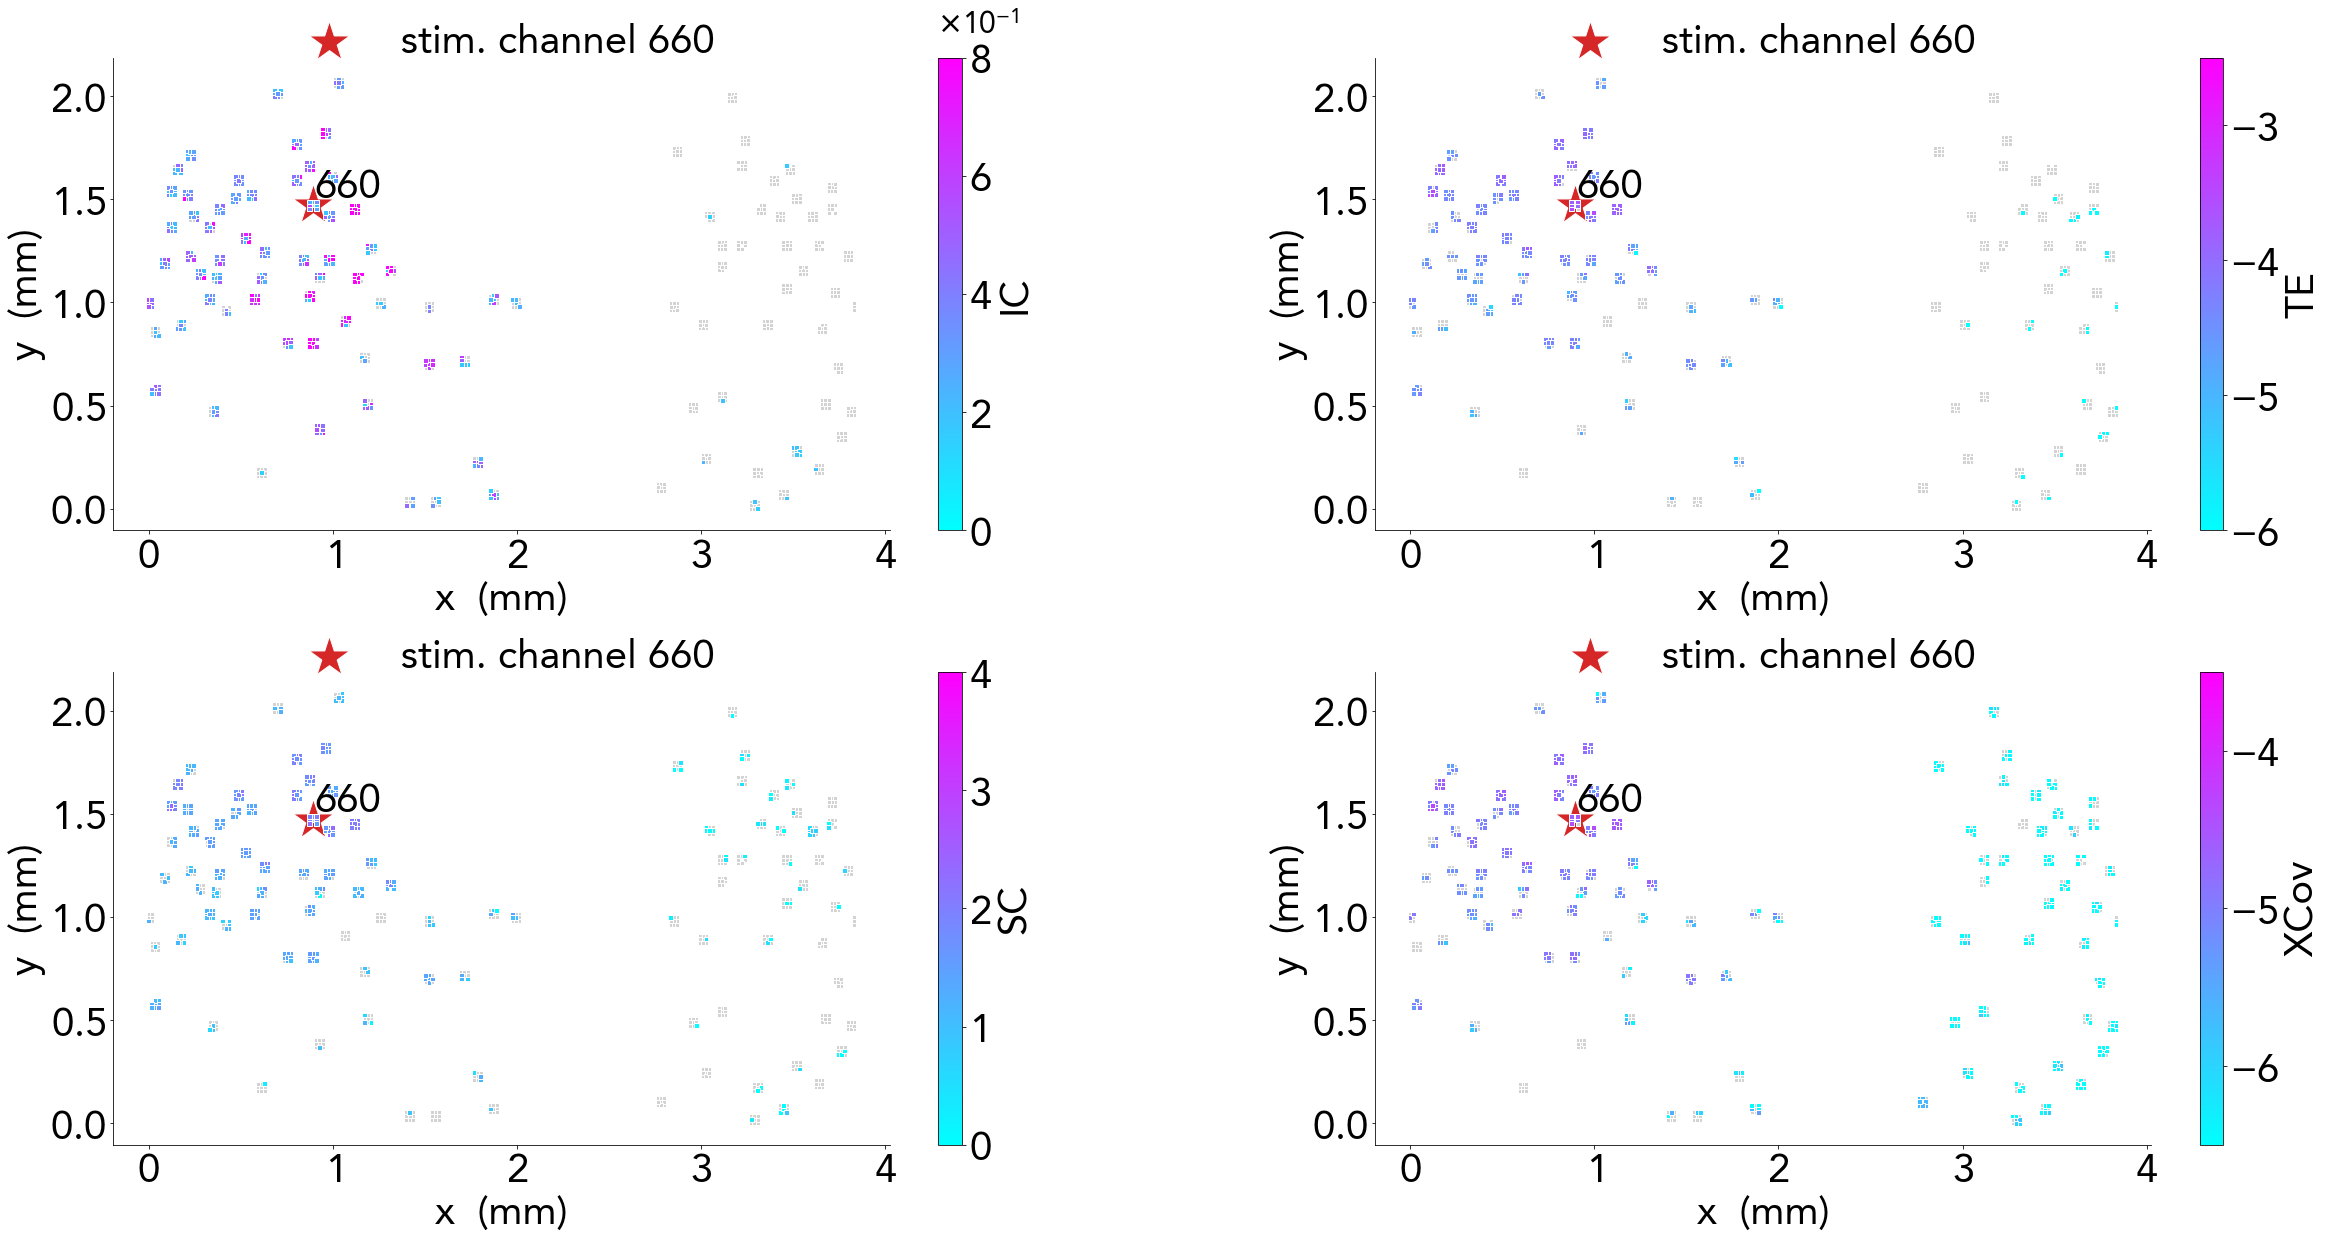

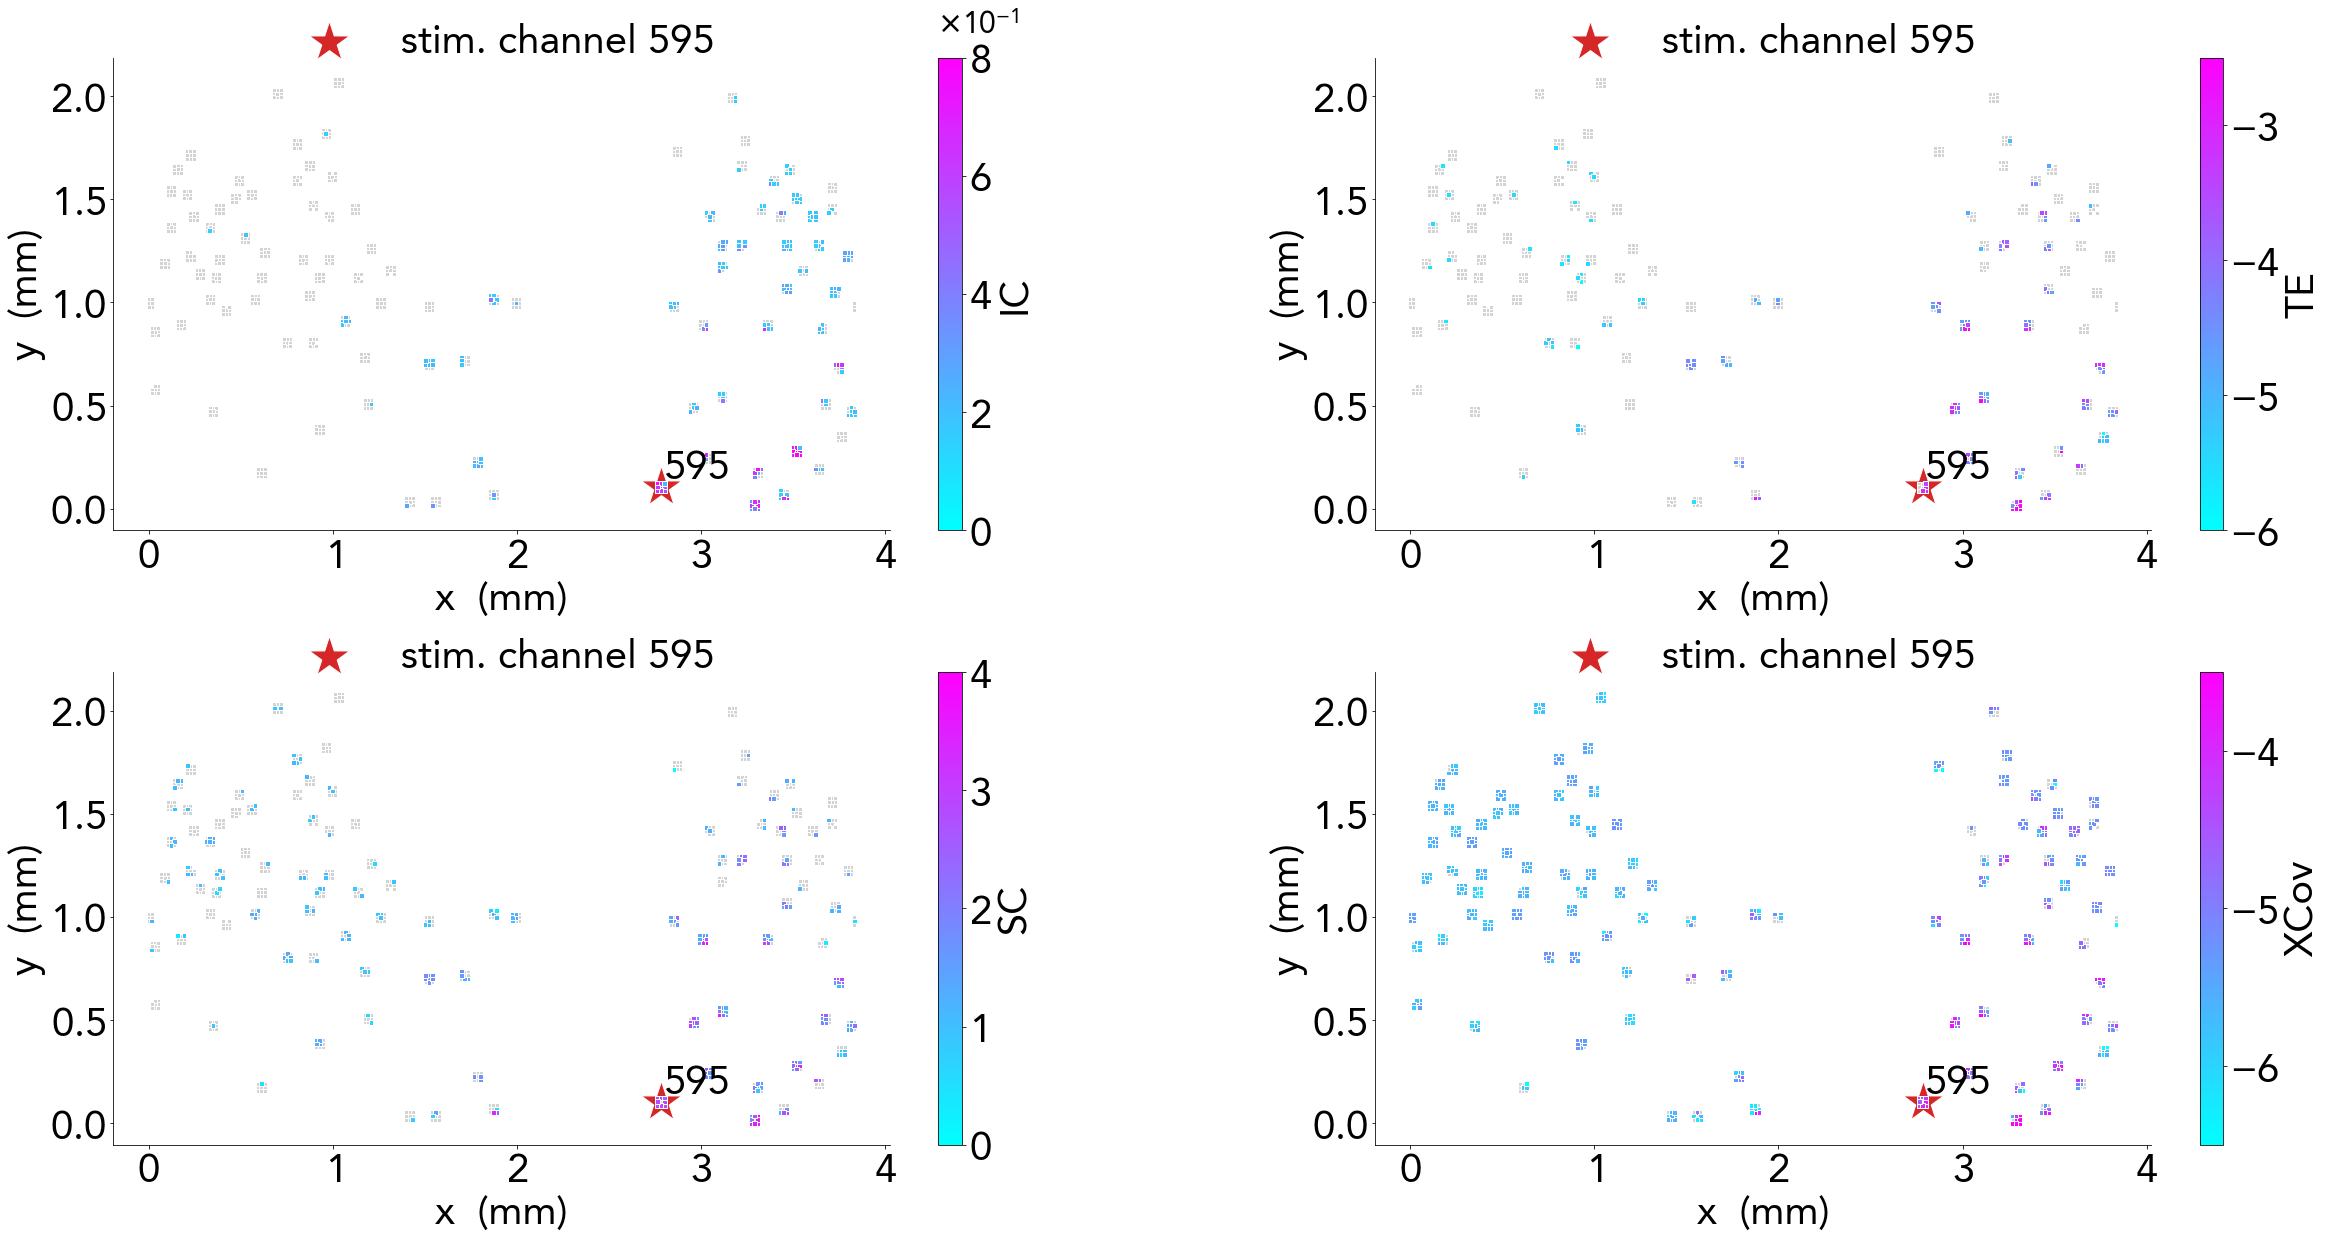

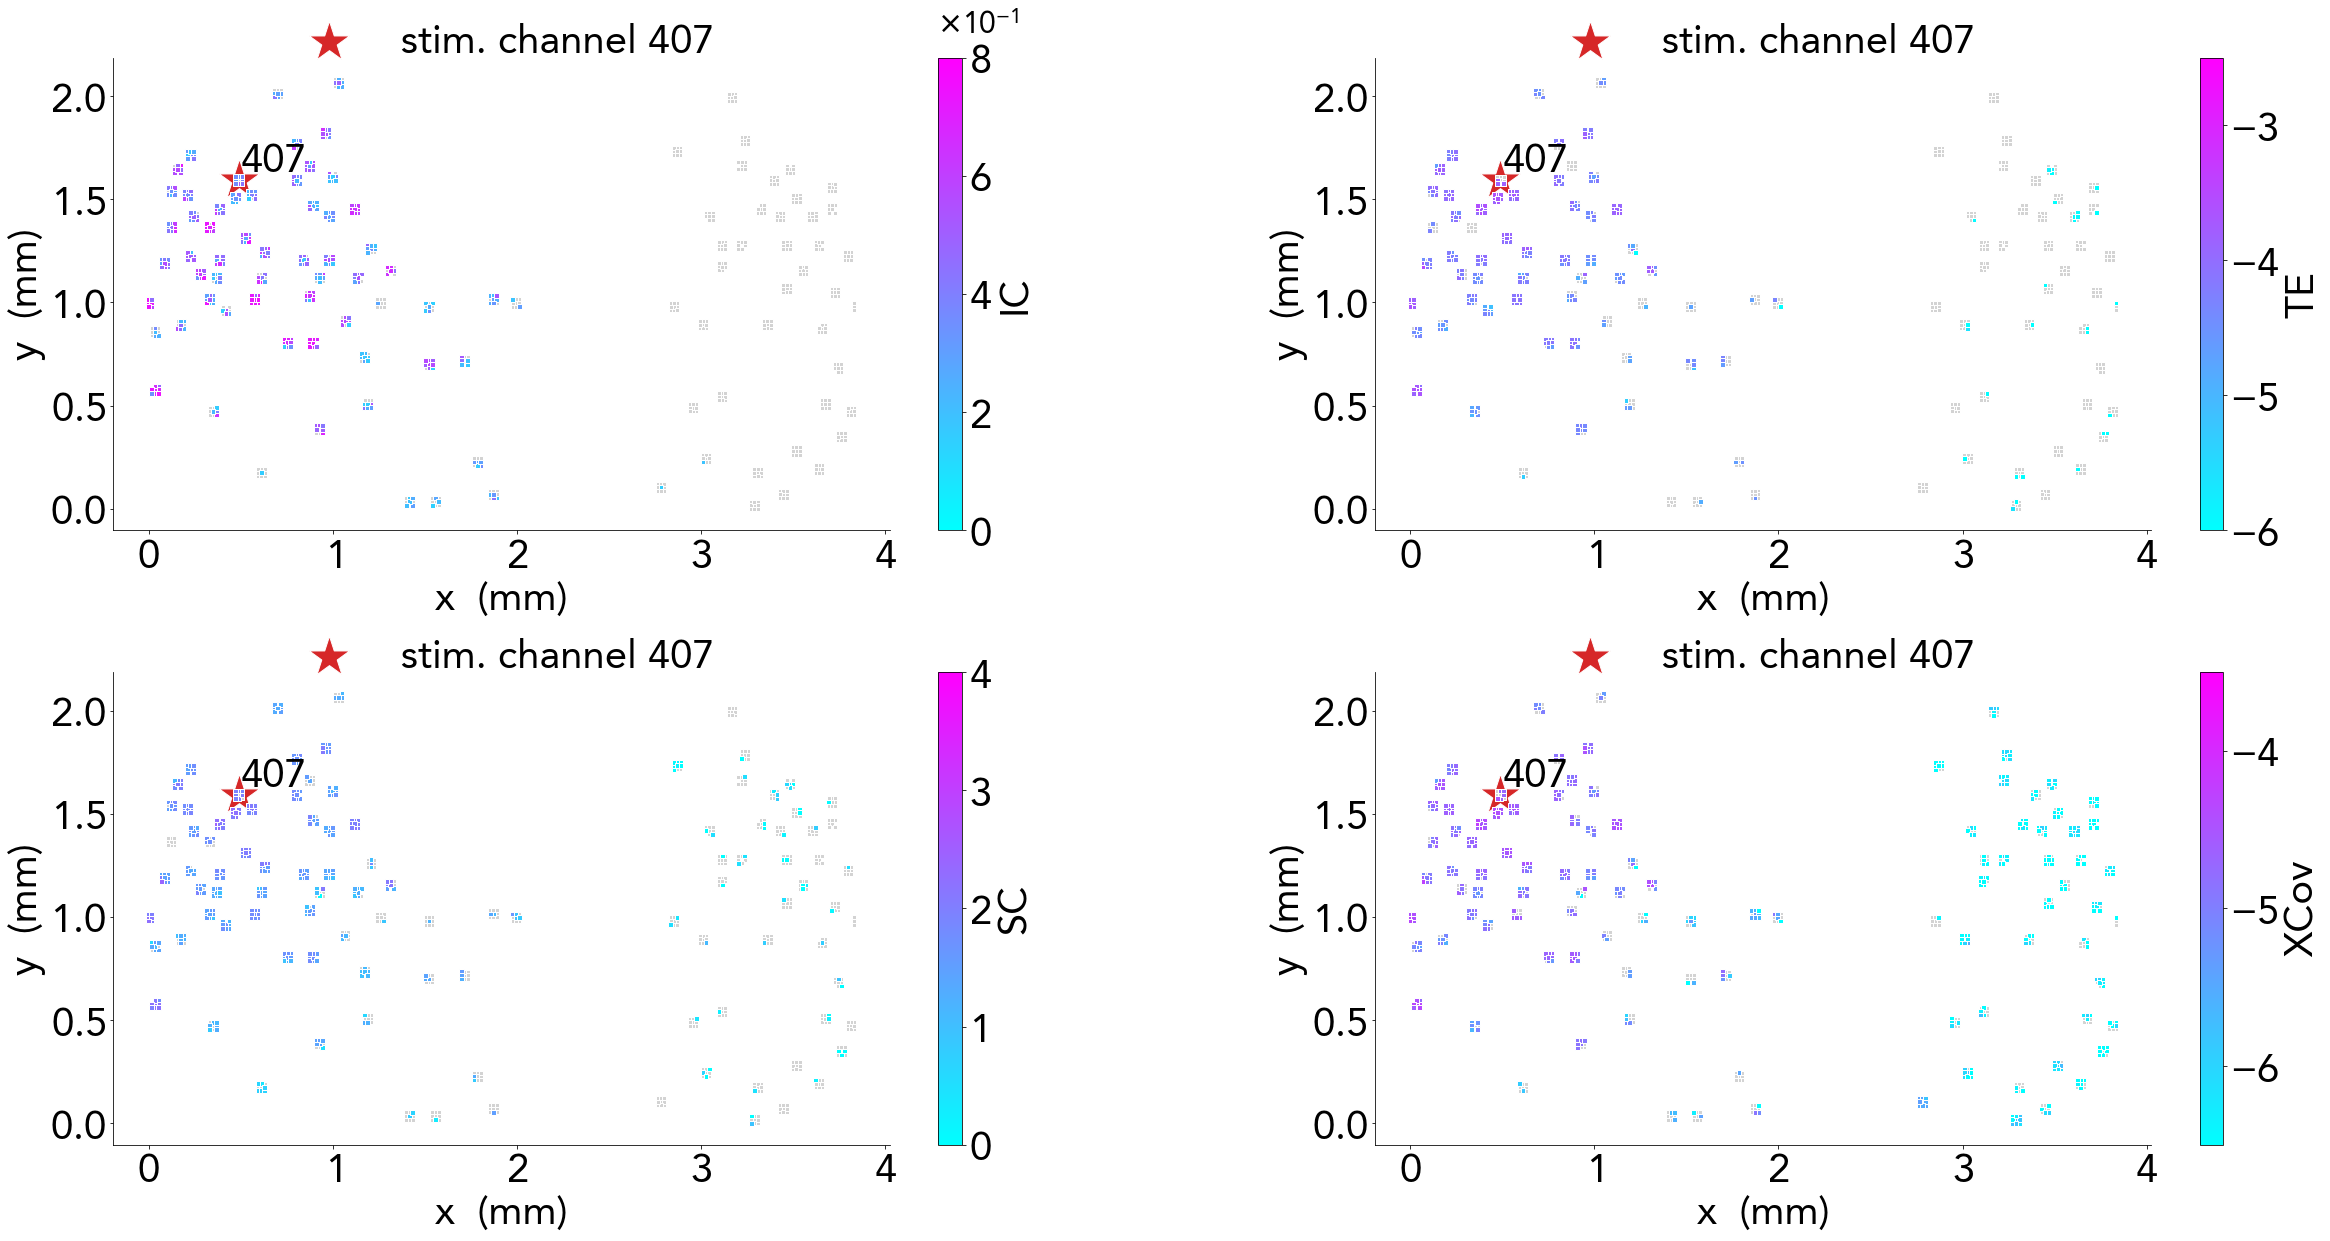

In [38]:
list_idxs = [660,595,407]
for idx in list_idxs:
    i = np.where(indices==idx)[0][0]

    fig,axs=plt.subplots(2,2,figsize=(40,20))
    pl.plot_perturbome(ks_sign, pos/1000, channel, indices, label='IC', stim_id=i, vmin=0, vmax=0.8, cmap='cool',
                   ax = axs[0,0], DIM=40, dotsize=22, starsize=1800)
    pl.plot_perturbome(TE_sign, pos/1000, channel, indices, label='TE', stim_id=i, vmin=-6, vmax=-2.5, cmap='cool', 
                    ax = axs[0,1], DIM=40, dotsize=22, starsize=1800, log=True)
    pl.plot_perturbome(SC_sign, pos/1000, channel, indices, label='SC', stim_id=i, vmin=0,  vmax=4,    cmap='cool', 
                    ax = axs[1,0], DIM=40, dotsize=22, starsize=1800, log=True)
    pl.plot_perturbome(XCov_sign,pos/1000,channel, indices, label='XCov',stim_id=i,vmin=-6.5,vmax=-3.5, cmap='cool', 
                    ax = axs[1,1], DIM=40, dotsize=22, starsize=1800, log=True)
    fig.subplots_adjust(wspace=0.3, hspace=0.3)
    plt.savefig(path_imgs + f'6_perturbomes_{indices[i]}.png', bbox_inches='tight')


<br>

# 7. Shortest Paths

In [39]:
# load Shortest paths matrices
pk_labs  = ['TE_sign','SC_sign','XCov_sign']
SP_pk = [np.load(path_IC_data+'SP_'+pk_labs[i]+'.npy') for i in range(len(pk_labs))]

SP_TE   = np.copy(SP_pk[0][indices,:]); SP_TE[np.isnan(SP_TE) | np.isinf(SP_TE)] = 1e8
SP_SC   = np.copy(SP_pk[1][indices,:]); SP_SC[np.isnan(SP_SC) | np.isinf(SP_SC)] = 1e8
SP_XCov = np.copy(SP_pk[2][indices,:]); SP_XCov[np.isnan(SP_XCov) | np.isinf(SP_XCov)] = 1e8

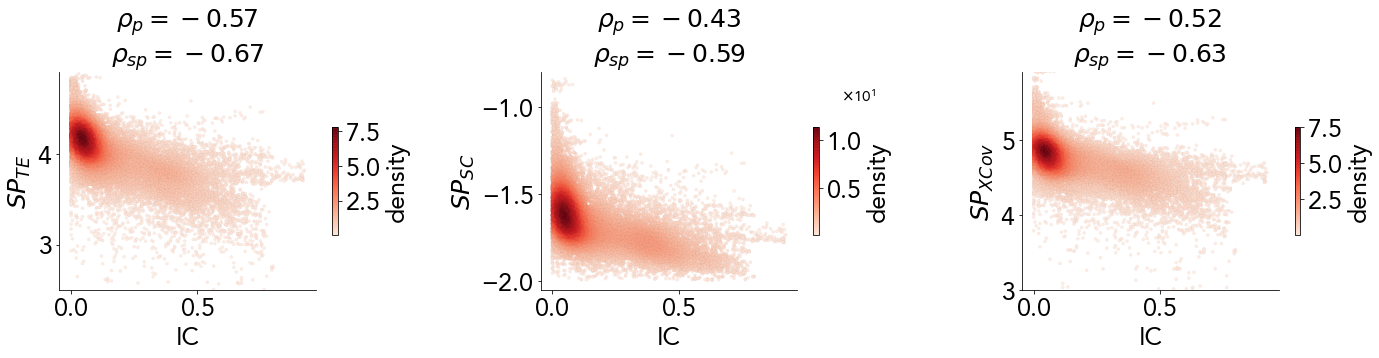

In [40]:
fig,axs=plt.subplots(1,3,figsize=(23,4)); cmap=truncate_cmap(plt.get_cmap('Reds'), minval=0.1, maxval=1)
pl.plot_scatter(ks[(SP_TE<1e8) & (SP_TE>0)],     SP_TE[(SP_TE<1e8) & (SP_TE>0)],       -11,  ymin=2.5,    ymax=4.9, reg_line=False, edgecolor='grey', linewidths=0.05,
                ylabel='$SP_{TE}$',   dotsize=10,  log=True, ax = axs[0], regcolor='k', cmap=cmap)
pl.plot_scatter(ks[(SP_SC<1e8) & (SP_SC>0)],     SP_SC[(SP_SC<1e8) & (SP_SC>0)],       -2,   ymin=-2.05, ymax=-0.8, reg_line=False, edgecolor='grey', linewidths=0.05,
                ylabel='$SP_{SC}$',   dotsize=10,  log=True,  ax = axs[1], regcolor='k', cmap=cmap)
pl.plot_scatter(ks[(SP_XCov<1e8) & (SP_XCov>0)], SP_XCov[(SP_XCov<1e8) & (SP_XCov>0)], -11,  ymin=3,    ymax=5.9, reg_line=False, edgecolor='grey', linewidths=0.05,
                ylabel='$SP_{XCov}$', dotsize=10,  log=True, ax = axs[2], regcolor='k', cmap=cmap)
fig.subplots_adjust(wspace=0.5, hspace=0.5)
plt.savefig(path_imgs + f'7.1_shortestPaths_wholeMats.png', bbox_inches='tight')


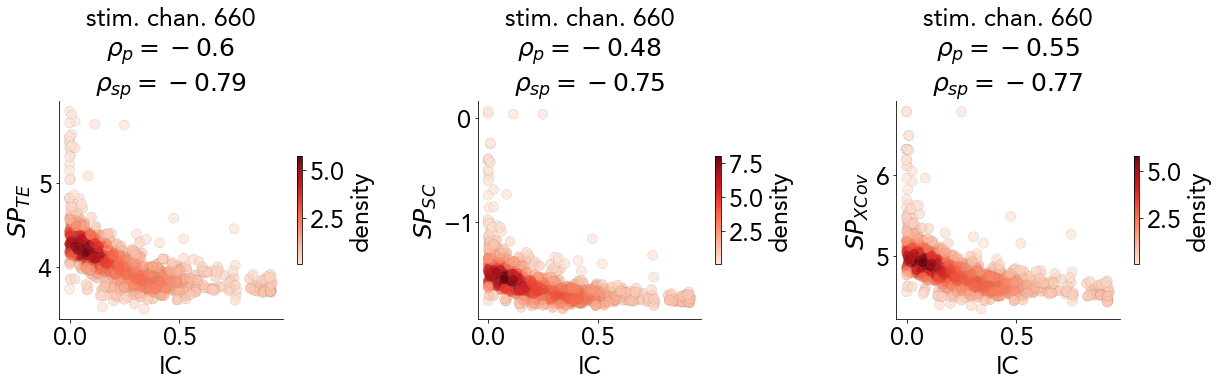

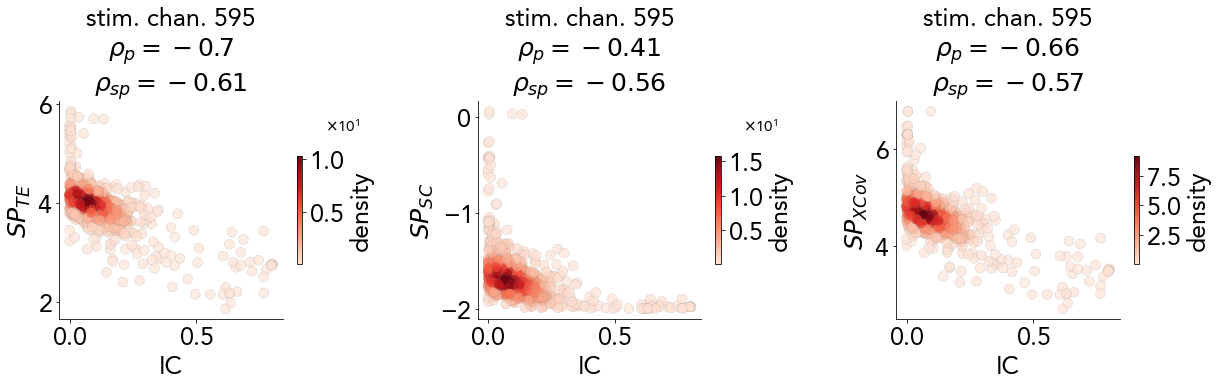

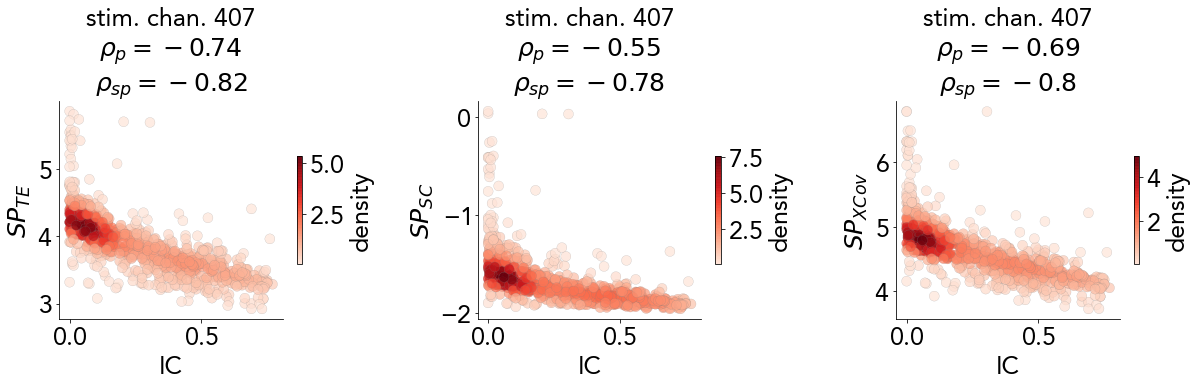

In [41]:
list_idxs = [660,595,407] # These are three of the stimulating channels in indices (the ones shown in the paper).
                          # Extend to for i in len(indices) to see the scatter plots for every stim. channel.
                          # Note: Stim. channels are named as idxs and not as channel IDs, 
                          #       You can obtain the channel-IDs with: channel[indices]
for idx in list_idxs:
    i = np.where(indices==idx)[0][0] # 601 for culture 2
    fig,axs=plt.subplots(1,3,figsize=(20,4))
    pl.plot_scatter(ks[i,(SP_TE[i]<1e8) & (SP_TE[i]>0)],     SP_TE[i,(SP_TE[i]<1e8) & (SP_TE[i]>0)],       -11, log=True, ylabel='$SP_{TE}$',   dotsize=100, reg_line=False, regcolor='tab:red', cmap=cmap, edgecolor='grey', linewidths=0.2, title=f'stim. chan. {indices[i]}', ax = axs[0])
    pl.plot_scatter(ks[i,(SP_SC[i]<1e8) & (SP_SC[i]>0)],     SP_SC[i,(SP_SC[i]<1e8) & (SP_SC[i]>0)],       -2,  log=True, ylabel='$SP_{SC}$',   dotsize=100, reg_line=False, regcolor='tab:red', cmap=cmap, edgecolor='grey', linewidths=0.2, title=f'stim. chan. {indices[i]}', ax = axs[1])
    pl.plot_scatter(ks[i,(SP_XCov[i]<1e8) & (SP_XCov[i]>0)], SP_XCov[i,(SP_XCov[i]<1e8) & (SP_XCov[i]>0)], -11, log=True, ylabel='$SP_{XCov}$', dotsize=100, reg_line=False, regcolor='tab:red', cmap=cmap, edgecolor='grey', linewidths=0.2, title=f'stim. chan. {indices[i]}', ax = axs[2])
    fig.subplots_adjust(wspace=0.5, hspace=0.5)
    plt.savefig(path_imgs + f'7.2_shortestPaths_source_{indices[i]}.png', bbox_inches='tight')


# 8. Spatial footprint

## 8.0 load distance matrix

In [42]:
dist_mat = (lec.load_mat(main_path, sim_folder, binsize=0.3, file_prefix='Cult_'+str(T_spont)+'min_', 
                        folder_prefix='ECdata_TE', ECmeas='DistanceMat', suffix='', mat_type='mat_d'))/1000
Dmat     = dist_mat[indices,:]

## 8.1 whole matrices

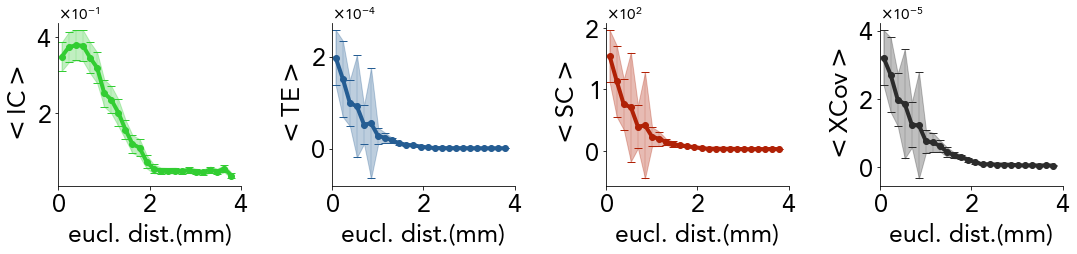

In [43]:
fig,axs=plt.subplots(1,4,figsize=(18,3))
pl.plot_binned_mean(ks,   Dmat, xlabel='eucl. dist.(mm)', ylabel='IC', color='limegreen', N_bins=25, xmax=4, ax=axs[0])
pl.plot_binned_mean(TE,   Dmat, xlabel='eucl. dist.(mm)', ylabel='TE',   color=colorz[0], N_bins=25, xmax=4, ax=axs[1])
pl.plot_binned_mean(SC,   Dmat, xlabel='eucl. dist.(mm)', ylabel='SC',   color=colorz[2], N_bins=25, xmax=4, ax=axs[2])
pl.plot_binned_mean(XCov, Dmat, xlabel='eucl. dist.(mm)', ylabel='XCov', color=colorz[4], N_bins=25, xmax=4, ax=axs[3])
fig.subplots_adjust(wspace=0.5, hspace=0.5)
plt.savefig(path_imgs + f'8.1_Cmean_distance_wholeMat.png', bbox_inches='tight')

## 8.2 fixed source channel

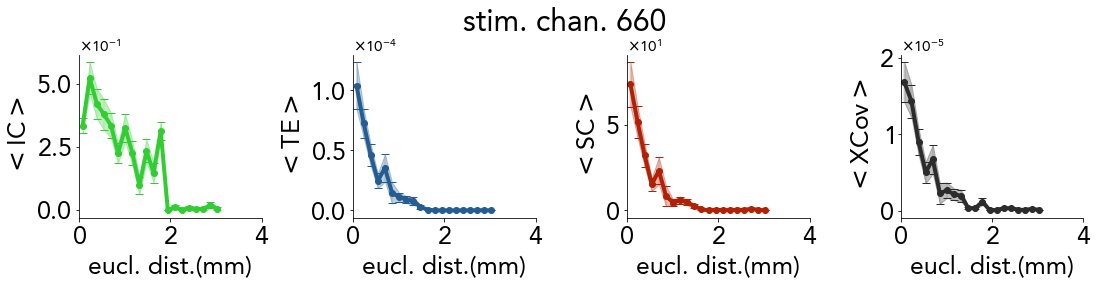

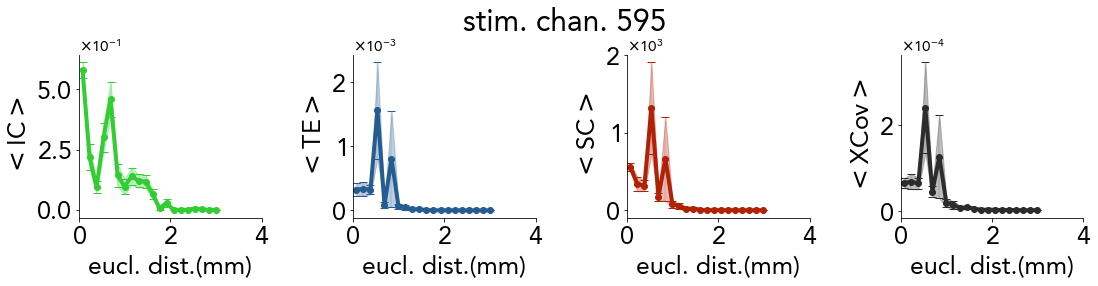

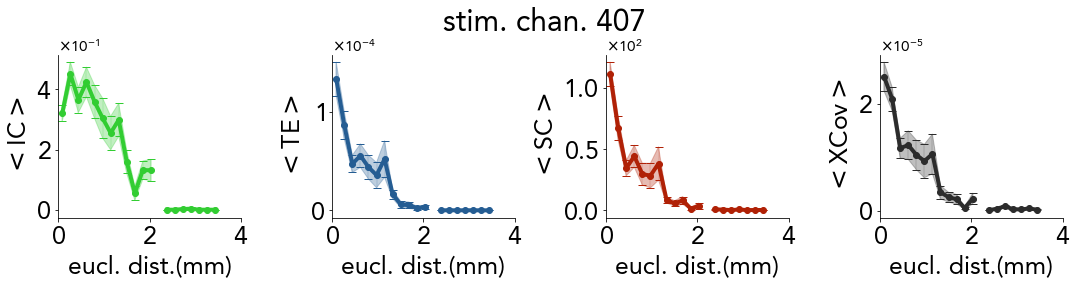

In [45]:
list_idxs = [660,595,407] 
for idx in list_idxs:
    i = np.where(indices==idx)[0][0] # 601 for culture 2

    fig,axs=plt.subplots(1,4,figsize=(18,3))
    pl.plot_binned_mean(ks_sign[i],   Dmat[i],  N_bins=20, xlabel='eucl. dist.(mm)', ylabel='IC',   color='limegreen', xmax=4, ax=axs[0])
    pl.plot_binned_mean(TE_sign[i],   Dmat[i],  N_bins=20, xlabel='eucl. dist.(mm)', ylabel='TE',   color=colorz[0],   xmax=4, ax=axs[1])
    pl.plot_binned_mean(SC_sign[i],   Dmat[i],  N_bins=20, xlabel='eucl. dist.(mm)', ylabel='SC',   color=colorz[2],   xmax=4, ax=axs[2])
    pl.plot_binned_mean(XCov_sign[i], Dmat[i],  N_bins=20, xlabel='eucl. dist.(mm)', ylabel='XCov', color=colorz[4],   xmax=4, ax=axs[3])
    fig.subplots_adjust(wspace=0.5, hspace=0.5)
    fig.suptitle(f'stim. chan. {indices[i]}',y=1.1)
    plt.savefig(path_imgs + f'8.2_Cmean_distance_source_{indices[i]}.png', bbox_inches='tight')
    

# 9. Probability of connection as a function of distance

## 9.1 whole matrices

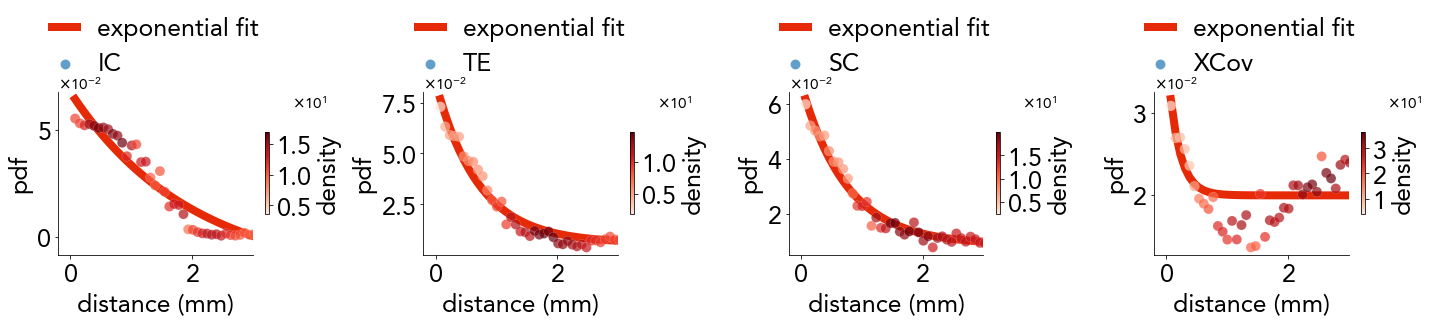

In [91]:
mats = [ks_sign, TE_sign, SC_sign, XCov_sign]; labs = ['IC','TE','SC','XCov']; colz = ['limegreen','#255D93','#B02106','#2C2C2C']
P_conn,dist_conn,params_conn = pl.fit_measure(mats, Dmat, N_bins=50, bounds=(-np.inf,np.inf))

fig,axs=plt.subplots(1,4,figsize=(24,3))
for i in range(4):
    pl.plot_fit_meas(P_conn[i], dist_conn[i], params_conn[i], colz[i], labs[i], ax=axs[i], xmax=3, cmap=cmap)
fig.subplots_adjust(wspace=0.5, hspace=0.5)


## 9.2 shource channel fixed

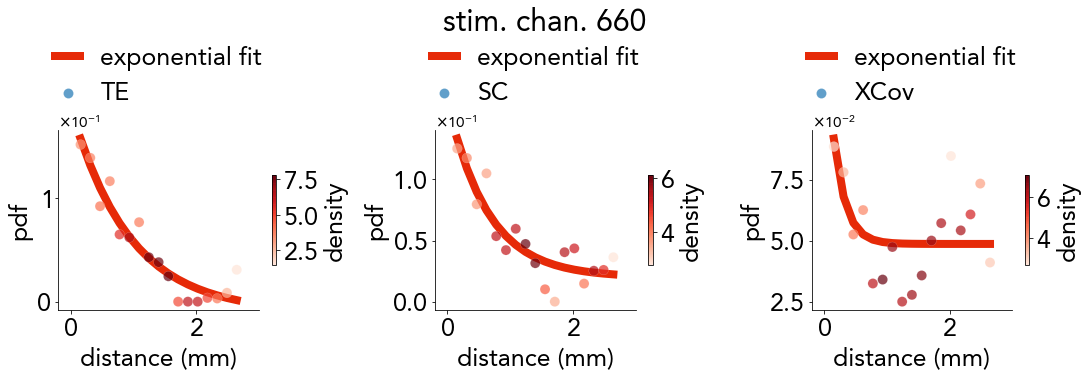

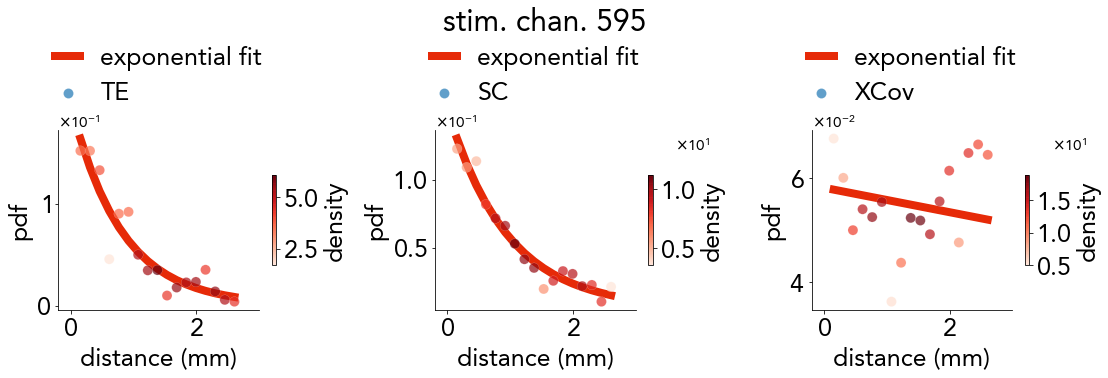

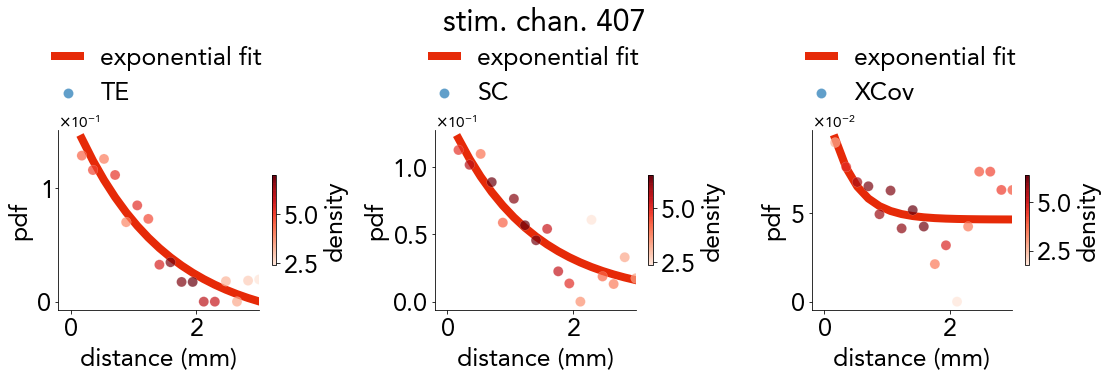

In [47]:
list_idxs = [660,595,407] 
for idx in list_idxs:
    i = np.where(indices==idx)[0][0] # 601 for culture 2
    
    mats = [TE_sign[i], SC_sign[i], XCov_sign[i]]; labs = ['TE','SC','XCov']; colz = ['#255D93','#B02106','#2C2C2C']
    P_conn,dist_conn,params_conn = pl.fit_measure(mats, Dmat[i], N_bins=20, bounds=(-np.inf,np.inf))

    fig,axs=plt.subplots(1,3,figsize=(18,3.3))
    for k in range(3):
        pl.plot_fit_meas(P_conn[k], dist_conn[k], params_conn[k], colz[k], labs[k], ax=axs[k], xmax=3, cmap=cmap)
    fig.subplots_adjust(wspace=0.5, hspace=0.5)
    fig.suptitle(f'stim. chan. {indices[i]}',y=1.4)
    plt.savefig(path_imgs + f'9.2_Pconn_source_{indices[i]}.png', bbox_inches='tight')


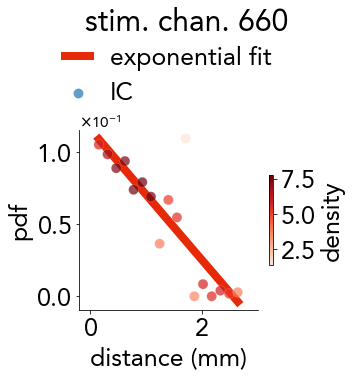

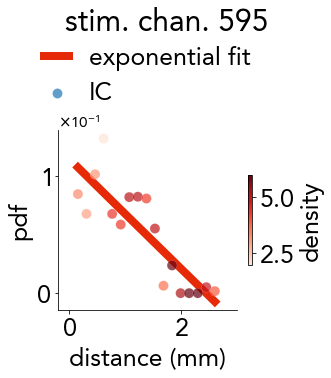

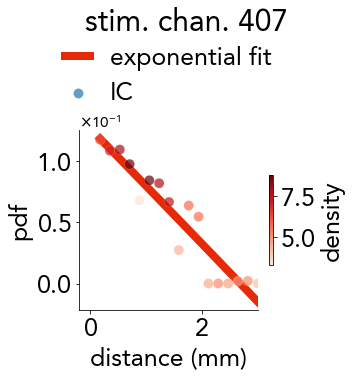

In [48]:
list_idxs = [660,595,407] 
for idx in list_idxs:
    i = np.where(indices==idx)[0][0] # 601 for culture 2
    
    mats = ks_sign[i]; labs = 'IC'; colz = 'limegreen'
    P_conn,dist_conn,params_conn = pl.fit_measure(mats, Dmat[i], N_bins=20, bounds=(-10,10))

    fig,axs=plt.subplots(1,1,figsize=(4,3.3))
    pl.plot_fit_meas(P_conn, dist_conn, params_conn, colz, labs, ax=axs, xmax=3, cmap=cmap)
    fig.subplots_adjust(wspace=0.5, hspace=0.5)
    fig.suptitle(f'stim. chan. {indices[i]}',y=1.4)
    plt.savefig(path_imgs + f'9.3_Pconn_IC_source_{indices[i]}.png', bbox_inches='tight')


# 10. EC/IC vs. distance

## 10.0 load distance matrix

In [49]:
dist_mat = (lec.load_mat(main_path, sim_folder, binsize=0.3, file_prefix='Cult_'+str(T_spont)+'min_', 
                        folder_prefix='ECdata_TE', ECmeas='DistanceMat', suffix='', mat_type='mat_d'))/1000
Dmat     = dist_mat[indices,:]

## 10.1 scatter EC as function of distance

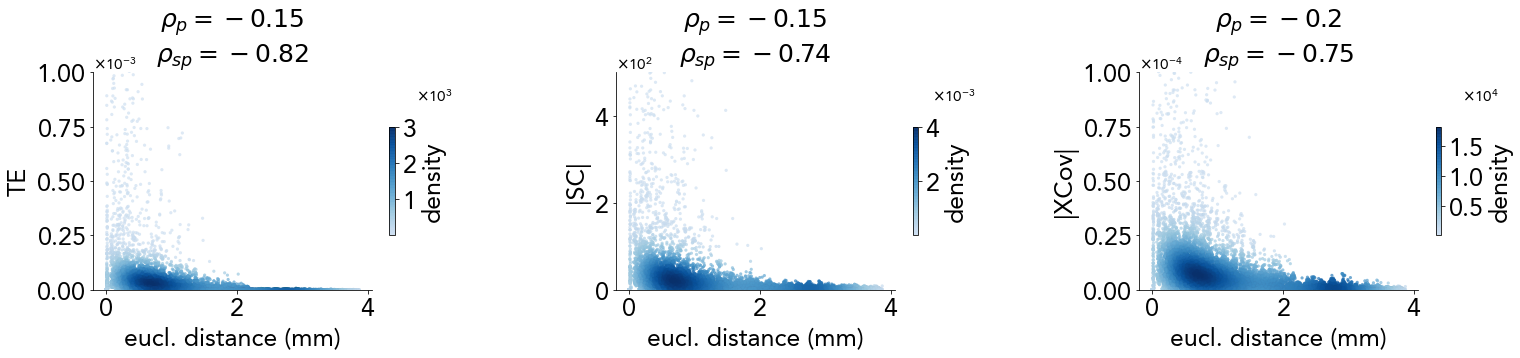

In [50]:
fig,axs=plt.subplots(1,3,figsize=(25,4)); cmap=truncate_cmap(plt.get_cmap('Blues'), minval=0.2, maxval=1)
pl.plot_scatter(Dmat, TE,   -11, xlabel='eucl. distance (mm)', ylabel='TE',    dotsize=10, edgecolor='grey', linewidths=0.01, reg_line=False, log=False, ymin=0, ymax=1E-3, ax = axs[0], regcolor='tab:red', cmap=cmap)
pl.plot_scatter(Dmat, SC,   -2,  xlabel='eucl. distance (mm)', ylabel='|SC|',  dotsize=10, edgecolor='grey', linewidths=0.01, reg_line=False, log=False, ymin=0, ymax=5E2,  ax = axs[1], regcolor='tab:red', cmap=cmap)
pl.plot_scatter(Dmat, XCov, -11, xlabel='eucl. distance (mm)', ylabel='|XCov|',dotsize=10, edgecolor='grey', linewidths=0.01, reg_line=False, log=False, ymin=0, ymax=1E-4, ax = axs[2], regcolor='tab:red', cmap=cmap)
fig.subplots_adjust(wspace=0.5, hspace=0.5)
plt.savefig(path_imgs + f'10.1_scatterDist_wholeMats.png', bbox_inches='tight')


## 10.2 fit – model selection with R$^2$, BIC and AIC

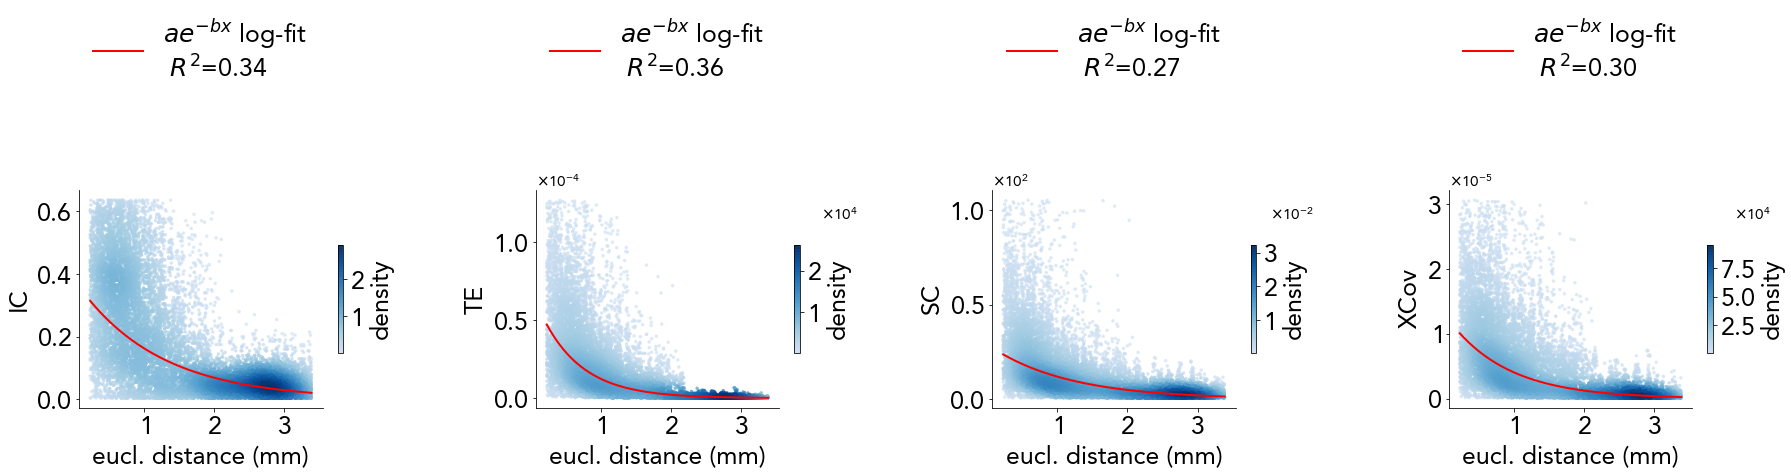

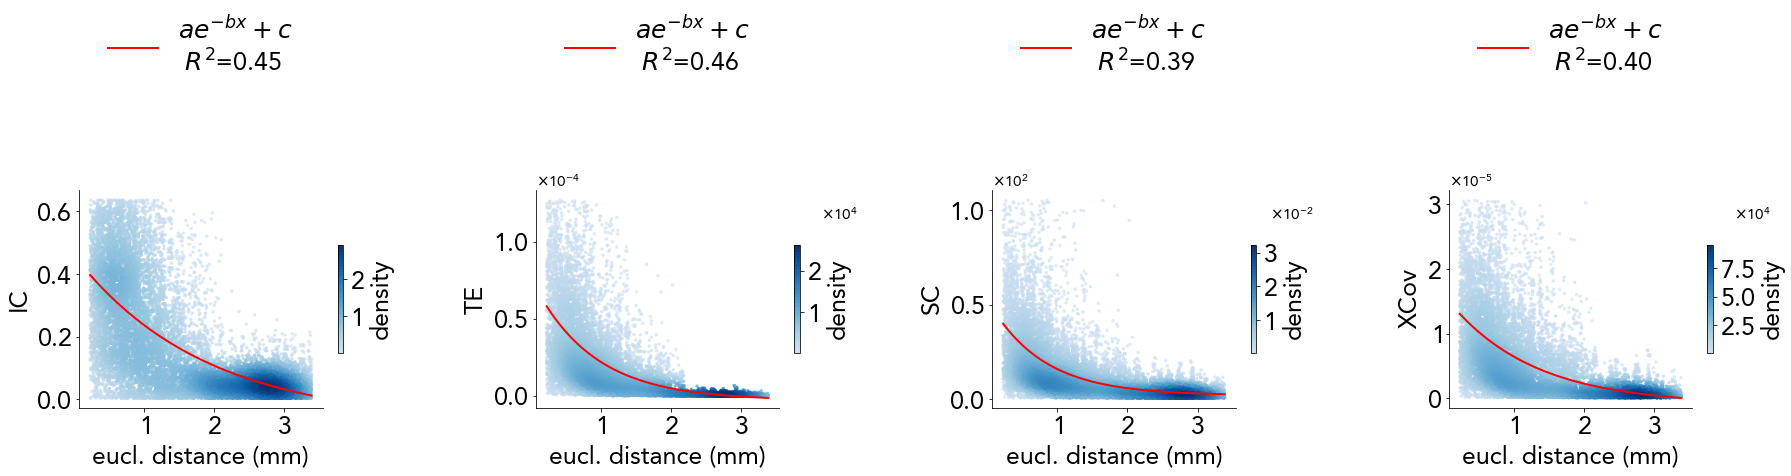

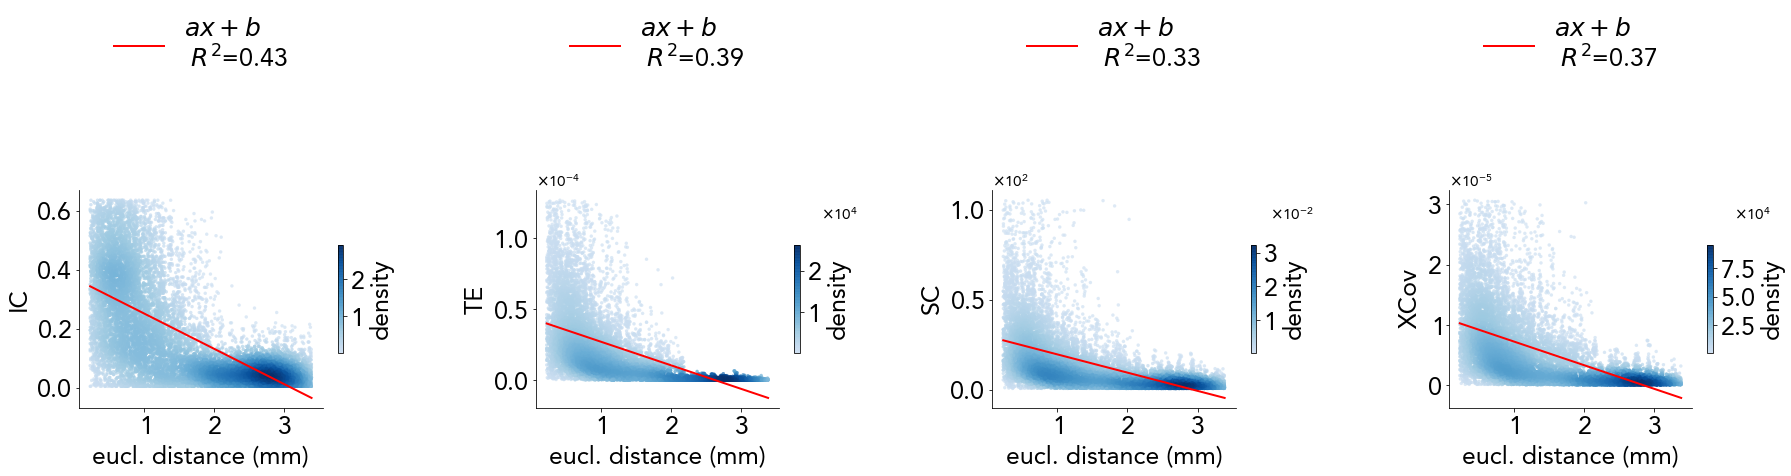

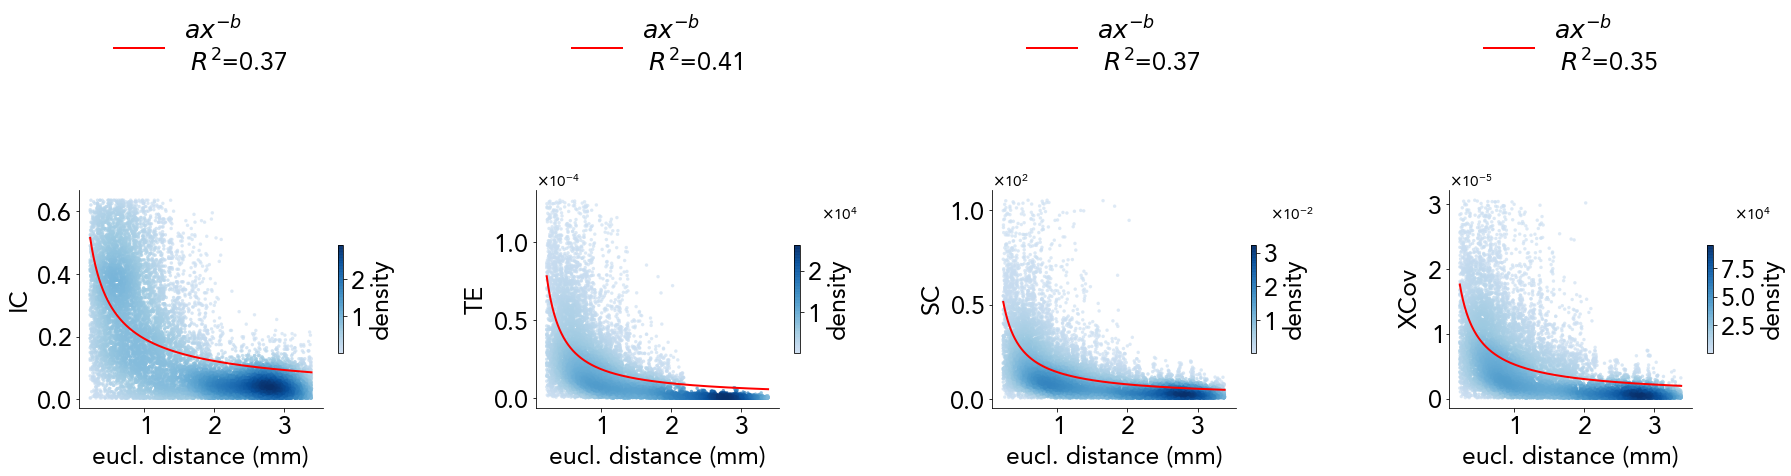

In [51]:
rm_quantiles=True
zth=5
q=0.04

for fit_type in ['log','exp','linear','power']:
    fig, axs = plt.subplots(1, 4, figsize=(30, 4))
    for ax, ydata, ylabel in zip(axs, [ks.flatten(), TE.flatten(), SC.flatten(), XCov.flatten()], ['IC', 'TE', 'SC', 'XCov']):
        popt, r2, aic, bic = di.fit_and_plot(Dmat.flatten(), ydata, ax=ax, dotsize=10, ylabel=ylabel, fit_type=fit_type,
                                         cmap=cmap, rm_quantiles=rm_quantiles, q=q, z_thresh=zth)
    fig.subplots_adjust(wspace=0.5, hspace=0.5)
    plt.savefig(path_imgs + f'10.2_fitDist_{fit_type}.png', bbox_inches='tight')


In [53]:
#== model selection ==#

rm_quantiles=True
zth=5
q=0.04

fit_types = ['log', 'exp', 'power', 'linear']
metrics = ['IC','TE', 'SC', 'XCov']
results = {metric: {'R2': [], 'AIC': [], 'BIC': []} for metric in metrics}

for fit_type in fit_types:
    for ydata, metric in zip([ks.flatten(), TE.flatten(), SC.flatten(), XCov.flatten()], metrics):
        popt, r2, aic, bic = pl.fit_and_plot(Dmat.flatten(), ydata, fit_type=fit_type, rm_quantiles=rm_quantiles, q=q, z_thresh=zth, plot=False)
        results[metric]['R2'].append(r2)
        results[metric]['AIC'].append(aic)
        results[metric]['BIC'].append(bic)


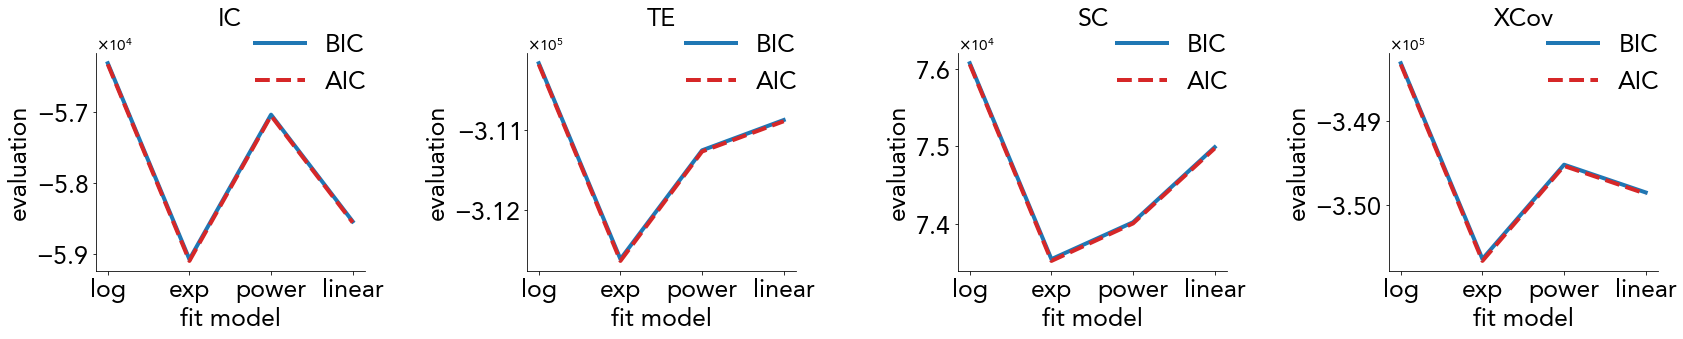

In [54]:
#== BIC and AIC ==#
fig, axs = plt.subplots(1, 4, figsize=(28, 4))
for i,m in enumerate(metrics):
    ax=axs[i]
    ax.plot(results[m]['BIC'], '-',  lw=4, color='tab:blue', label='BIC')
    ax.plot(results[m]['AIC'], '--', lw=4, color='tab:red',label='AIC')
    ax.set_xlabel("fit model")
    ax.set_ylabel('evaluation')
    pl.set_format(ax=ax,DIM=DIM)
    ax.set_xticks(np.arange(len(fit_types)))
    ax.set_xticklabels(fit_types)
    ax.legend(loc='upper center', bbox_to_anchor=(0.8, 1.2), frameon=False)
    ax.set_title(m,y=1.1)
fig.subplots_adjust(wspace=0.6, hspace=0.5)
plt.savefig(path_imgs + f'10.2_fitDist_BIC-AIC.png', bbox_inches='tight')

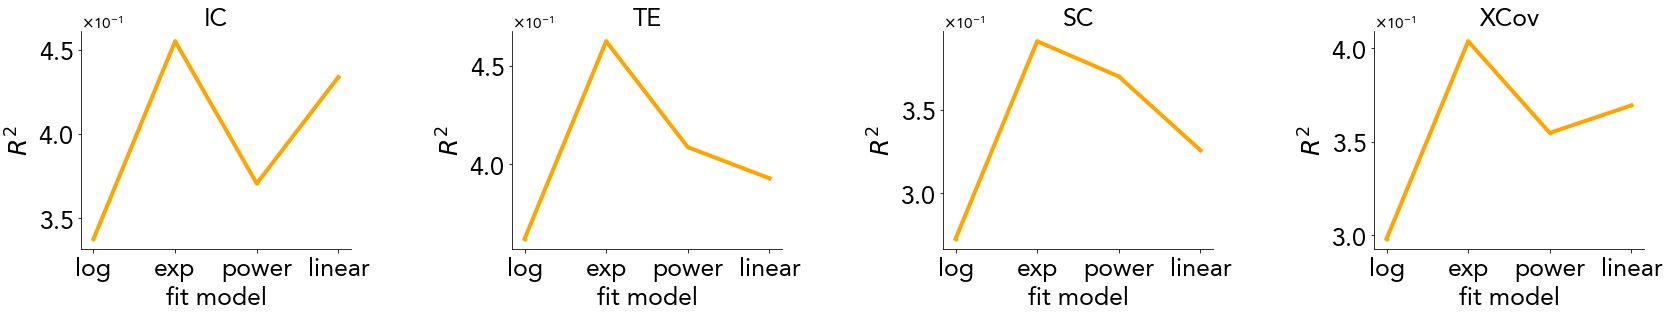

In [55]:
#== R^2 ==#
fig, axs = plt.subplots(1, 4, figsize=(28, 4))
for i,m in enumerate(metrics):
    ax=axs[i]
    ax.plot(results[m]['R2'], '.-', lw=4, color='orange')
    ax.set_xlabel("fit model")
    ax.set_ylabel('$R^2$')
    pl.set_format(ax=ax,DIM=DIM)
    ax.set_xticks(np.arange(len(fit_types)))
    ax.set_xticklabels(fit_types)
    ax.set_title(m)
fig.subplots_adjust(wspace=0.6, hspace=0.5)
plt.savefig(path_imgs + f'10.2_fitDist_R2.png', bbox_inches='tight')

## 10.3 optimizing the outliers exclusion

In [57]:
rm_quantiles=True
Q_range=np.arange(0.0,0.5,0.01)

results_q = {metric: {'R2': [], 'AIC': [], 'BIC': []} for metric in metrics}
for q in Q_range:
    for ydata, metric in zip([ks.flatten(), TE.flatten(), SC.flatten(), XCov.flatten()], metrics):
        popt, r2, aic, bic = pl.fit_and_plot(Dmat.flatten(), ydata, fit_type=fit_type, rm_quantiles=rm_quantiles, q=q, z_thresh=zth, plot=False)
        results_q[metric]['R2'].append(r2)
        results_q[metric]['AIC'].append(aic)
        results_q[metric]['BIC'].append(bic)

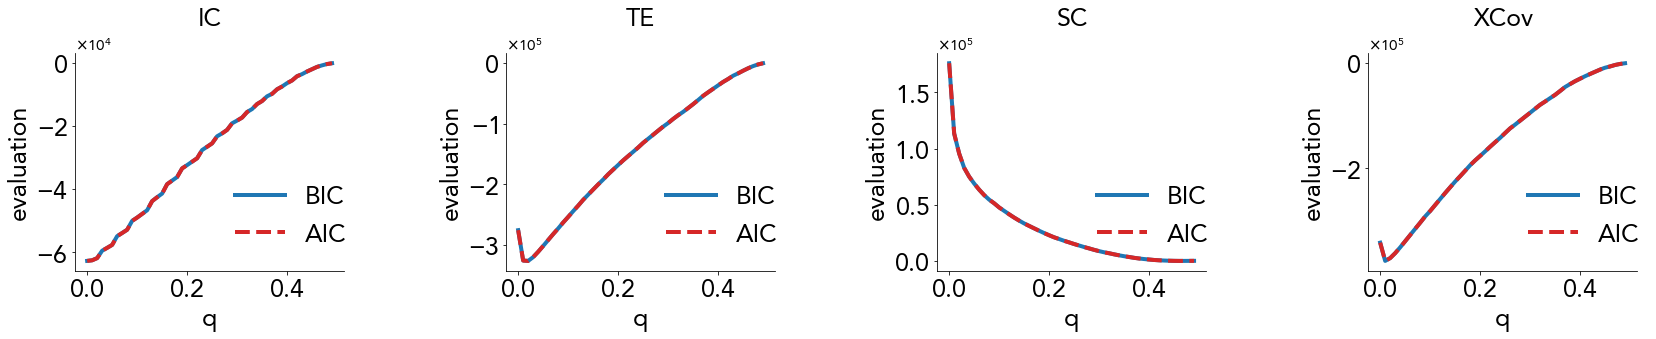

In [58]:
#== BIC and AIC ==#
fig, axs = plt.subplots(1, 4, figsize=(28, 4))
for i,m in enumerate(metrics):
    ax=axs[i]
    ax.plot(Q_range, results_q[m]['BIC'], '-',  lw=4, color='tab:blue', label='BIC')
    ax.plot(Q_range, results_q[m]['AIC'], '--', lw=4, color='tab:red',label='AIC')
    ax.set_xlabel("q")
    ax.set_ylabel('evaluation')
    pl.set_format(ax=ax,DIM=DIM,pwr_x_min=-3)

    ax.legend(loc='upper center', bbox_to_anchor=(0.8, 0.5), frameon=False)
    ax.set_title(m,y=1.1)
fig.subplots_adjust(wspace=0.6, hspace=0.5)
plt.savefig(path_imgs + f'10.3_fitDist_BIC-AIC.png', bbox_inches='tight')


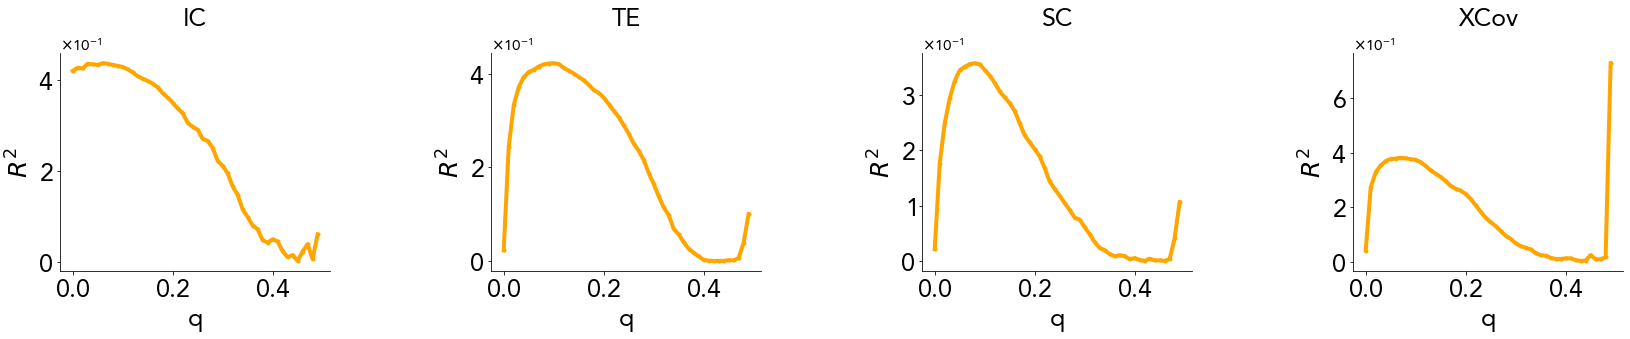

In [59]:
#== R^2 ==#

fig, axs = plt.subplots(1, 4, figsize=(28, 4))
for i,m in enumerate(metrics):
    ax=axs[i]
    ax.plot(Q_range, results_q[m]['R2'], '.-', lw=4, color='orange')
    ax.set_xlabel("q")
    ax.set_ylabel('$R^2$')
    pl.set_format(ax=ax,DIM=DIM,pwr_x_min=-3)
    ax.set_title(m,y=1.1)
fig.subplots_adjust(wspace=0.6, hspace=0.5)
plt.savefig(path_imgs + f'10.3_fitDist_R2.png', bbox_inches='tight')

## 10.4 compute residuals from exponential fit (for IC and EC)

In [63]:
def eval_fit_func(x, popt, fit_type='exp'):
    if fit_type == 'exp':
        return di.exp_func(x, *popt)
    elif fit_type == 'linear':
        return di.linear_func(x, *popt)
    elif fit_type == 'power':
        return di.power_func(x, *popt)
    elif fit_type == 'log':
        return di.log_func(x, *popt)  # se hai una definizione
    else:
        raise ValueError(f"Fit type {fit_type} non supportato.")

def compute_residuals_from_popt(Dmat, matrices, metrics, params_dict, fit_type='exp'):
    resid_dict = {}
    x = Dmat.flatten()
    for ydata, metric in zip(matrices, metrics):
        y    = ydata.flatten()
        popt = params_dict[metric]

        y_pred = eval_fit_func(x, *popt, fit_type=fit_type)
        resid  = y - y_pred
        
        resid  = resid.reshape(Dmat.shape)
        y_pred = y_pred.reshape(Dmat.shape)
        
        resid_dict[metric] = resid

    return resid_dict


In [64]:
# compute residuals
metrics = ['IC','TE', 'SC', 'XCov']
fit_type='exp'
rm_quantiles=True
q=0.01
popt_results={metric: [] for metric in metrics}
for ydata, metric in zip([ks, TE, SC, XCov], metrics):
    popt, _, _, _ = pl.fit_and_plot(Dmat.flatten(), ydata.flatten(), fit_type=fit_type, rm_quantiles=rm_quantiles, q=q, z_thresh=zth, plot=False)
    popt_results[metric].append(popt)

residuals = compute_residuals_from_popt(Dmat, [ks, TE, SC, XCov], metrics, popt_results, fit_type='exp')


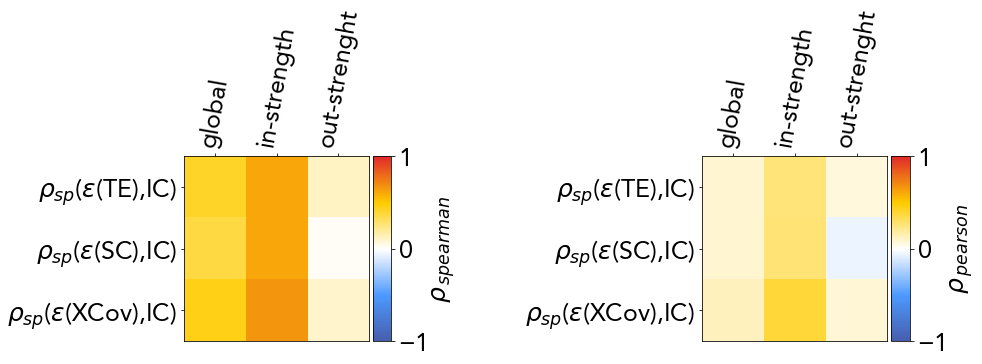

In [65]:
res_mats = [residuals[m] for m in metrics[1:]]
res_labs = [r'$\epsilon$(TE)',r'$\epsilon$(SC)',r'$\epsilon$(XCov)']
res_ks   = residuals['IC']

res_Scorr, res_Pcorr         = cc.corrMeasures(res_mats, res_ks, indices, compute_strength=False)
res_Scorr_in, res_Pcorr_in   = cc.corrMeasures(res_mats, res_ks, indices, compute_strength=True)
res_Scorr_out, res_Pcorr_out = cc.corrMeasures_outStr(res_mats,  res_ks, indices)

res_Scorr_all = np.vstack([res_Scorr, res_Scorr_in, res_Scorr_out])
res_Pcorr_all = np.vstack([res_Pcorr, res_Pcorr_in, res_Pcorr_out])

# PLOT corr matrices
fig,axs = plt.subplots(1,2,figsize=(13,4.5))
cc.plot_corr_matrix(res_Scorr_all.T,res_labs,r'$\rho_{{\,spearman}}$', ax=axs[0])
cc.plot_corr_matrix(res_Pcorr_all.T,res_labs,r'$\rho_{{\,pearson}}$', ax=axs[1])
fig.subplots_adjust(wspace=1.5, hspace=0.5)
plt.savefig(path_imgs + '10.4_ECrecAcc_wholeMats.png', bbox_inches='tight')


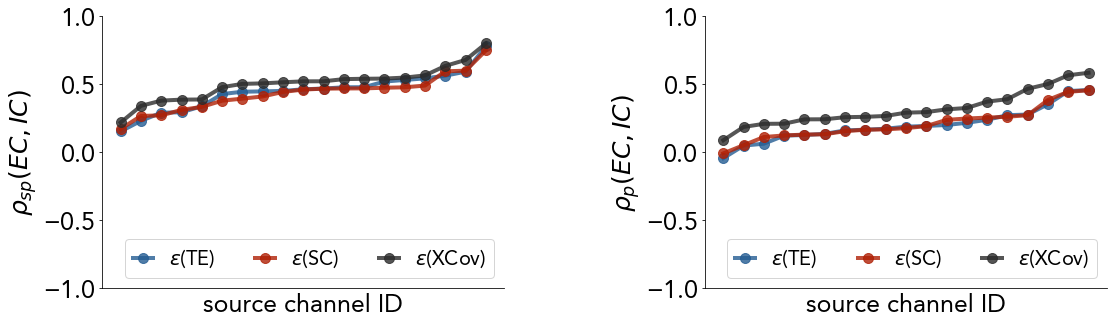

In [66]:
res_spearman, res_spearman_p = cc.correlate_source_fixed(res_mats, res_ks, exclude_zeros=False)
res_cpearson, res_cpearson_p = cc.correlate_source_fixed(res_mats, res_ks, exclude_zeros=False, pearson=True)

fig,axs = plt.subplots(1,2,figsize=(18,5))
cc.plot_correlations(res_spearman, res_labs, ylabel=r'$\rho_{sp}(EC,IC)$', ax=axs[0]) # spearman
cc.plot_correlations(res_cpearson, res_labs, ylabel=r'$\rho_{p}(EC,IC)$',  ax=axs[1])  # pearson
fig.subplots_adjust(wspace=0.5, hspace=0.5)
plt.savefig(path_imgs + '10.4.2_ECrecAcc_source.png', bbox_inches='tight')

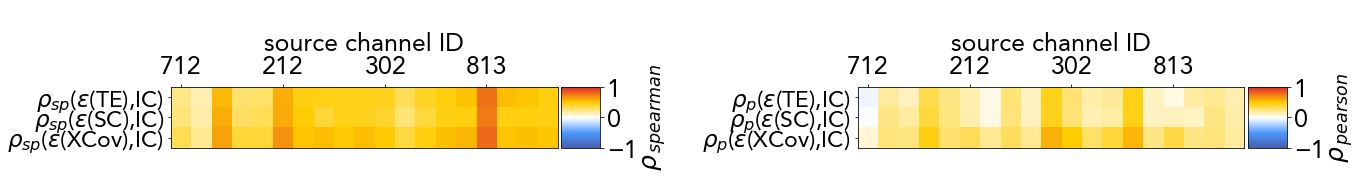

In [67]:
fig,axs = plt.subplots(1,2,figsize=(20,5))
cc.plot_corr_elements(res_spearman, res_labs, indices, r' ', ax=axs[0]) # spearman
cc.plot_corr_elements(res_cpearson, res_labs, indices,  r' ', label=r'$\rho_{{\,pearson}}$',pearson=True, ax=axs[1]) # pearson
fig.subplots_adjust(wspace=0.6, hspace=0.5)
plt.savefig(path_imgs + '10.4.2_ECrecAcc_source_2.png', bbox_inches='tight')

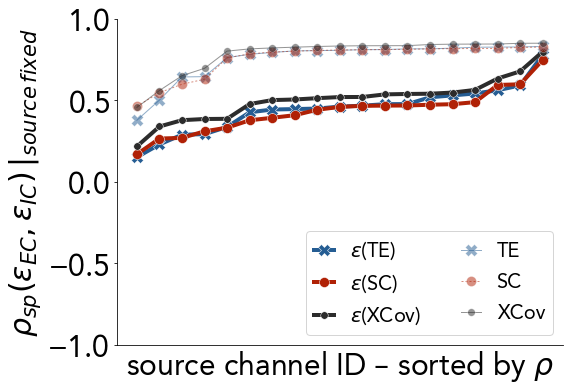

In [416]:
plotcorrs( res_spearman, spearman, res_labs, labs, show_plot=True)

In [415]:
def plotcorrs(corr_mat, corr_mat_2, label_list, label_list2, outf: str = None, show_plot: bool = False):
    DIM = 30
    #colors_dl = ['#255D93', '#5FA6D6', '#B02106', '#F24D33', '#2C2C2C', '#787878']
    colors_dl = ['#255D93', '#B02106', '#2C2C2C']
    
    fig, ax = plt.subplots(figsize=(8, 6))
    
    #--------------------------------------------------------------------------------------------#
    # CORRECTED WITH DISTANCE
    #--------------------------------------------------------------------------------------------#
    idx_plot=0
    L = np.argsort(corr_mat[idx_plot])
    line, = ax.plot(corr_mat[idx_plot][L], 'X-', markersize=12, markeredgecolor='white', markeredgewidth=0.5,
                    color=colors_dl[idx_plot], label=label_list[idx_plot], lw=4, alpha=1)
    #-------------------------------------
    idx_plot=1
    L = np.argsort(corr_mat[idx_plot])
    line, = ax.plot(corr_mat[idx_plot][L], '.-', markersize=20, markeredgecolor='white', markeredgewidth=0.5,
                    color=colors_dl[idx_plot], label=label_list[idx_plot], lw=4, alpha=1)
    #-------------------------------------
    idx_plot = 2
    L = np.argsort(corr_mat[idx_plot])
    line, = ax.plot(corr_mat[idx_plot][L], '.-', markersize=15, markeredgecolor='white', markeredgewidth=0.5,
                    color=colors_dl[idx_plot], label=label_list[idx_plot], lw=4, alpha=1)

    #--------------------------------------------------------------------------------------------#
    # NON CORRECTED WITH DISTANCE
    #--------------------------------------------------------------------------------------------#
    idx_plot=0
    L = np.argsort(corr_mat_2[idx_plot])
    line, = ax.plot(corr_mat_2[idx_plot][L], 'X-', markersize=12, markeredgecolor='white', markeredgewidth=0.5,
        color=colors_dl[idx_plot], label=label_list2[idx_plot], 
                    lw=1, alpha=0.5)
    #-------------------------------------
    idx_plot=1
    L = np.argsort(corr_mat_2[idx_plot])
    line, = ax.plot(corr_mat_2[idx_plot][L], '.-', markersize=20, markeredgecolor='white', markeredgewidth=0.5,
        color=colors_dl[idx_plot], label=label_list2[idx_plot], 
                    lw=1, alpha=0.5)
    line.set_dashes([2, 2])
    #-------------------------------------
    idx_plot=2
    L = np.argsort(corr_mat_2[idx_plot])
    line, = ax.plot(corr_mat_2[idx_plot][L], '.-', markersize=15, markeredgecolor='white',markeredgewidth=0.5,
            color=colors_dl[idx_plot], 
                    label=label_list2[idx_plot], 
                    lw=1, alpha=0.5)
    #--------------------------------------------------------------------------------------------#

    #--------------------------------------------------------------------------------------------#
    ax.set_xlabel(r'source channel ID – sorted by $\rho$', fontsize=DIM)
    ax.set_ylabel(r'$\rho_{sp}(\epsilon_{EC},\epsilon_{IC})\,|_{source\, fixed}$', fontsize=DIM)
    ax.set_ylim(-1, 1)
    #-------------------------------------
    ax.legend(fontsize=DIM-10, loc='lower right', ncol=2, handlelength=1)
    
    ax.set_xticks([])
    pl.set_format(ax, axis_ticks = 'both', DIM = DIM)
    
    if outf:
        plt.savefig(outf, bbox_inches='tight')

    if show_plot == False:
        plt.close()
        


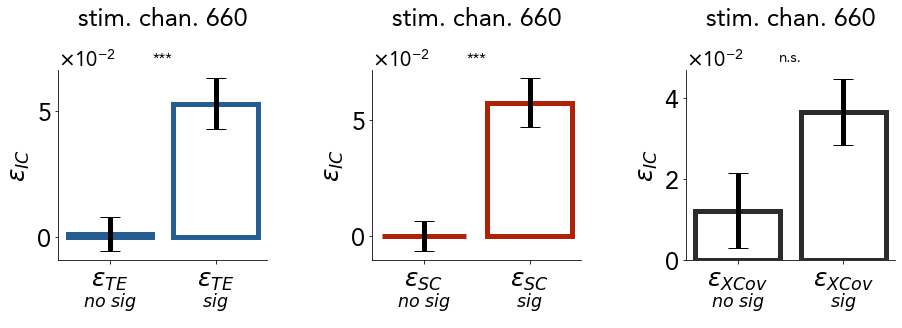

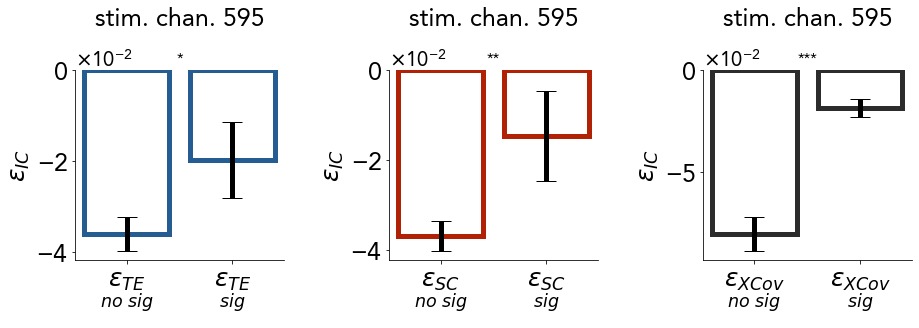

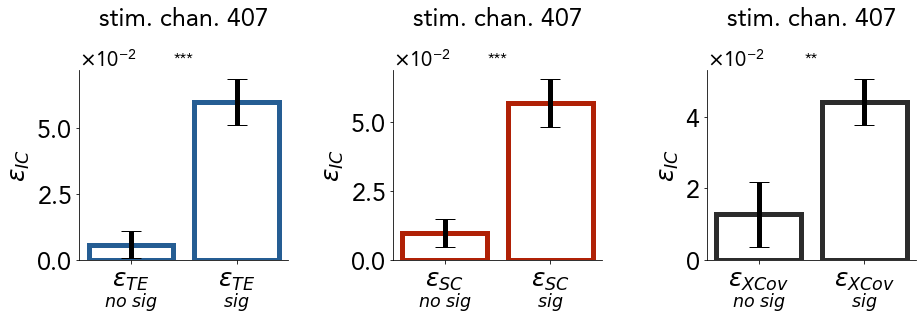

In [68]:
res_mats = [residuals[m] for m in metrics[1:]]

list_idxs = [660,595,407] # These are three of the stimulating channels in indices (the ones shown in the paper).
                          # Extend to for i in len(indices) to see the scatter plots for every stim. channel.
                          # Note: Stim. channels are named as idxs and not as channel IDs, 
                          #       You can obtain the channel-IDs with: channel[indices]
for idx in list_idxs:
    i = np.where(indices==idx)[0][0] # 601 for culture 2

    fig,axs=plt.subplots(1,3,figsize=(15,3.5))
    pl.plot_bars(res_ks[i,:], res_mats[0][i,:], r'$\epsilon_{IC}$', r'$\epsilon_{TE}$',   TE_Pval[i,:],   colorz[0], title=f'stim. chan. {indices[i]}', colBar='black', doubleP=True, alpha_th = 0.001, ax=axs[0])
    pl.plot_bars(res_ks[i,:], res_mats[1][i,:], r'$\epsilon_{IC}$', r'$\epsilon_{SC}$',   SC_Pval[i,:],   colorz[2], title=f'stim. chan. {indices[i]}', colBar='black', doubleP=True, alpha_th = 0.001, ax=axs[1])
    pl.plot_bars(res_ks[i,:], res_mats[2][i,:], r'$\epsilon_{IC}$', r'$\epsilon_{XCov}$', XCov_Pval[i,:], colorz[4], title=f'stim. chan. {indices[i]}', colBar='black', doubleP=True, alpha_th = 0.001, ax=axs[2])
    fig.subplots_adjust(wspace=0.5, hspace=0.5)
    plt.savefig(path_imgs + f'10.4.3_source_bar_{indices[i]}.png', bbox_inches='tight')


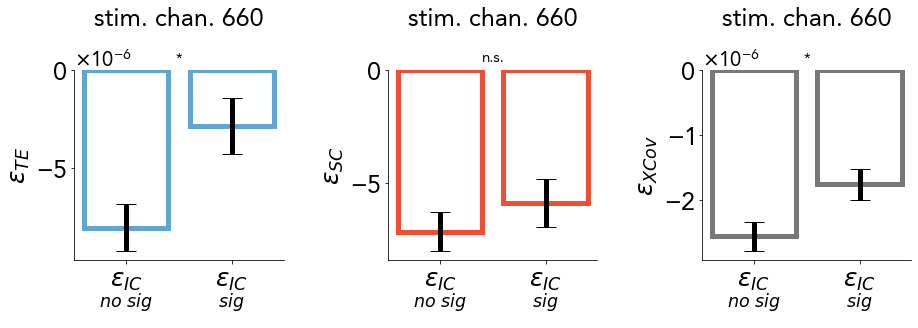

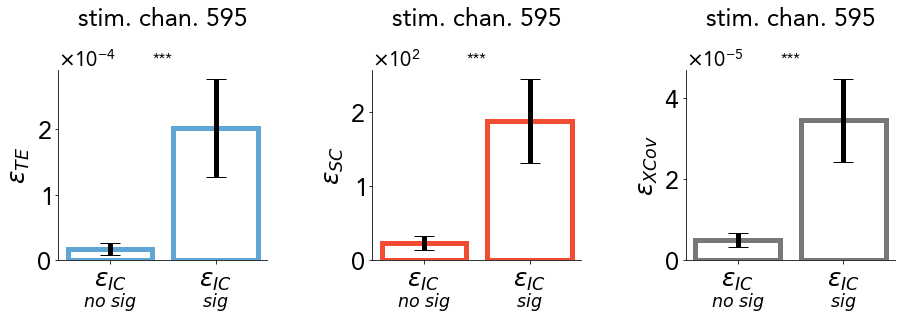

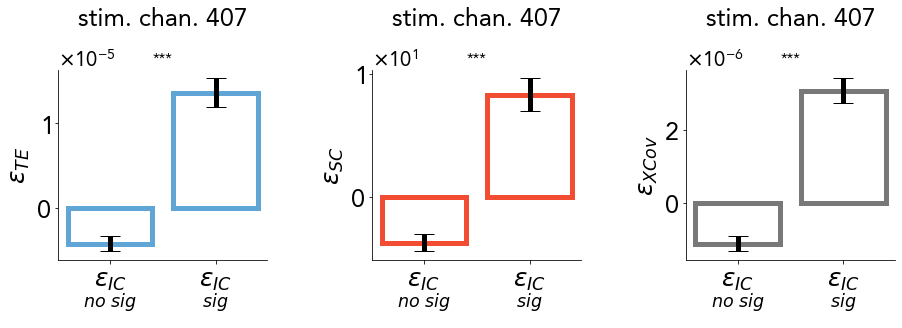

In [69]:
list_idxs = [660,595,407]
for idx in list_idxs:
    i = np.where(indices==idx)[0][0]

    fig,axs=plt.subplots(1,3,figsize=(15,3.5))
    pl.plot_bars(res_mats[0][i,:], res_ks[i,:], r'$\epsilon_{TE}$',  r'$\epsilon_{IC}$', ks_pval[i,:], colorz[1], title=f'stim. chan. {indices[i]}', colBar='black', doubleP=True, alpha_th = 0.001, ax=axs[0])
    pl.plot_bars(res_mats[1][i,:], res_ks[i,:], r'$\epsilon_{SC}$',  r'$\epsilon_{IC}$', ks_pval[i,:], colorz[3], title=f'stim. chan. {indices[i]}', colBar='black', doubleP=True, alpha_th = 0.001, ax=axs[1])
    pl.plot_bars(res_mats[2][i,:], res_ks[i,:], r'$\epsilon_{XCov}$',r'$\epsilon_{IC}$', ks_pval[i,:], colorz[5], title=f'stim. chan. {indices[i]}', colBar='black', doubleP=True, alpha_th = 0.001, ax=axs[2])
    fig.subplots_adjust(wspace=0.5, hspace=0.5)
    plt.savefig(path_imgs + f'10.4.4_source_bar_{indices[i]}.png', bbox_inches='tight')


In [447]:
def scatter_residuals(mat, lab, res_mat, res_lab, IC, res_IC, pval_IC, i, indices_, 
                      reg_line=False, ymin:float=None,ymax:float=None):

    ec_v  = mat[i]
    ic_v  = IC[i]
    res_e = res_mat[i]
    res_i = res_IC[i]
    p_IC  = pval_IC[i]
    
    cols_  = ['#E93423','#3333F6','#999AF8','#030062']

    fig,axs = plt.subplots(1,2,figsize=(13,4))
    
    ax=axs[0]
    ax.scatter(ic_v[p_IC<0.05], ec_v[p_IC<0.05], s=150,c=cols_[0],edgecolor='white')
    ax.scatter(ic_v[p_IC>=0.05],ec_v[p_IC>=0.05],s=150,c=cols_[2],edgecolor='white')

    if reg_line:
        sns.regplot(x=ic_v, y=ec_v, scatter=False, ax=ax, line_kws=dict(color=colorz[4]))
    
    pl.set_format(ax=ax)
    ax.set_xlabel('IC')
    ax.set_ylabel(lab)
    ax.set_xlim(0,1)
    ax.set_title(fr'$\rho_{{sp}}={np.round(spearmanr(ec_v,ic_v)[0],2)}$'+
                 '\n'+fr'$\rho_{{p}}={np.round(pearsonr(ec_v,ic_v)[0],2)}$',y=1.1)
    
    ax=axs[1]
    ax.scatter(res_i[p_IC<0.05], res_e[p_IC<0.05], s=150,c=cols_[0],edgecolor='white')
    ax.scatter(res_i[p_IC>=0.05],res_e[p_IC>=0.05],s=150,c=cols_[2],edgecolor='white')

    if reg_line:
        sns.regplot(x=res_i, y=res_e, scatter=False, ax=ax, line_kws=dict(color=colorz[4]))
    
    pl.set_format(ax=ax)
    ax.set_xlabel('$\epsilon_{IC}$')

    ax.set_ylabel(f'$\epsilon_{{{lab}}}$')
    if ymin!=None and ymax!=None:
        ax.set_ylim(ymin,ymax)
    ax.set_title(fr'$\rho_{{sp}}={np.round(spearmanr(res_e,res_i)[0],2)}$'+
                 '\n'+fr'$\rho_{{p}}={np.round(pearsonr(res_e,res_i)[0],2)}$',y=1.1)
    
    #-------------------------------------------------------------------------------------------#
    
    fig.subplots_adjust(wspace=0.5, hspace=0.7)
    fig.suptitle(f'stim. chan. {indices_[i]}',y=1.3)
    

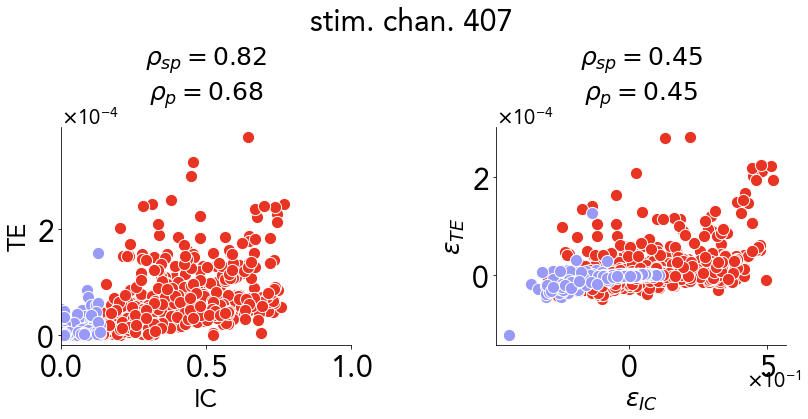

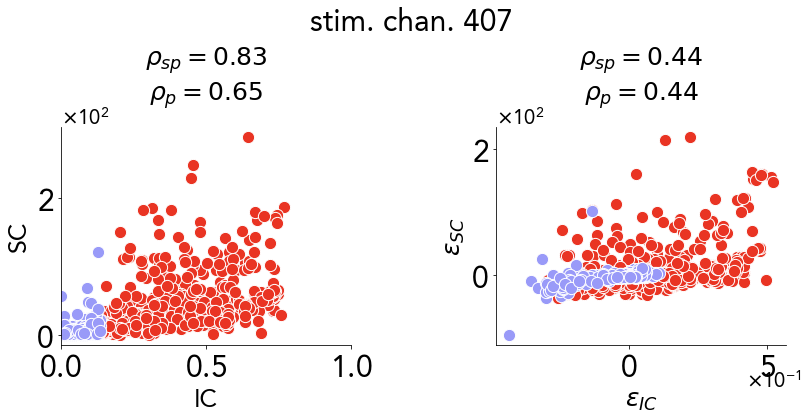

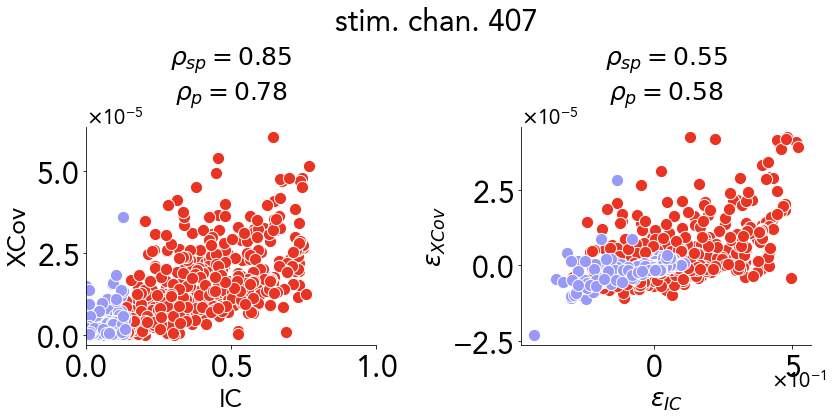

In [449]:
scatter_residuals(TE, 'TE', residuals['TE'], '$\epsilon_{TE}$', ks, res_ks, ks_pval, i, indices, reg_line=False)
scatter_residuals(SC, 'SC', residuals['SC'], '$\epsilon_{SC}$', ks, res_ks, ks_pval, i, indices, reg_line=False)
scatter_residuals(XCov, 'XCov', residuals['XCov'], '$\epsilon_{XCov}$', ks, res_ks, ks_pval, i, indices, reg_line=False)


